<h4><center>Rodrigo Morel - Lizeth Contreras - Martín Fernando Ortiz</center></h4>
<h3><center> Maestría de Geomática - UNLP</center></h3>
<h3><center>Geoestadística </center></h3>
<h3><center>Análisis de datos meteorológicos</center></h3>

#
## 


### Objetivo General
Aplicar de técnicas de geoestadística para el análisis de datos meteorológicos

### Objetivos Específicos
- Hacer un análisis descriptivo de la información del dataset
- Tratar los datos outliers
- Realizar un análisis PCA
- Generar una interpolación para el caso en que tengamos No Datos
- Hacer predicción de datos para un nuevo dataset de estaciones
- Realizar un análisis PCA
- Utilizar alguna técnica de Cluster para generar regiones climatológicas

### Software utilizado
Jupyter / Colab - Python

### Dataset utilizado
Dataset de la cátedra de Geoestadística


In [77]:
#!pip install rasterio geopandas
#!pip install gdal
#!pip install Fiona
#!pip install RISE
#!pip install seaborn


In [78]:
# @title
# Carga de librerías
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import seaborn as sns

import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon
from shapely.geometry import box

import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio import features
from rasterio.features import geometry_mask

import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans


from sklearn.cluster import KMeans

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.interpolate import griddata

from joblib import dump, load

#from osgeo import gdal as gdal
#from osgeo import ogr as ogr
#from osgeo import osr

#from google.colab import drive
#drive.mount('/content/drive')

## Corrección del Dataset



- Corrección de Coordenadas


In [79]:
# @title
#df_coords = pd.read_csv('/content/drive/My Drive/datasets_colab/final/smn_coord.csv')
df_coords = pd.read_csv('smn_coord.csv')


#df_original = pd.read_csv('/content/drive/My Drive/datasets_colab/final/SMN_estaciones_medias_mensuales_1989_2010.csv')
df_original = pd.read_csv('SMN_estaciones_medias_mensuales_1989_2010.csv')


#country_boundaries = gpd.read_file('/content/drive/My Drive/datasets_colab/final/pais.gpkg')
country_boundaries = gpd.read_file('pais.gpkg')
pais=country_boundaries

#archivo = "SMN_estaciones_medias_mensuales_1989_2010.xls"
#df = pd.read_excel(archivo)

In [80]:

def plot_geo_dataframes(pais, df_coords, df_original):
    """
    Plotea dos GeoDataFrames en subgráficos, comparando coordenadas corregidas y sin corregir.

    Parameters:
    - pais: GeoDataFrame, capa de polígonos (límites del país).
    - df_coords: DataFrame, datos con coordenadas corregidas.
    - df_original: DataFrame, datos sin corregir.
    """

    gdf = gpd.GeoDataFrame(df_coords, geometry=gpd.points_from_xy(df_coords['long'], df_coords['lat']), crs='EPSG:4326')
    gdf1 = gpd.GeoDataFrame(df_original, geometry=gpd.points_from_xy(df_original['long'], df_original['lat']), crs='EPSG:4326')

    # Crear el mapa con dos subgráficos (1 fila, 2 columnas)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # ---- Plotear el primer DataFrame (gdf) ----
    ax = axs[1]  # Seleccionar el primer subgráfico

    # Plotear la capa de polígonos (límites del país)
    pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

    # Plotear la capa de puntos con colores basados en alguna columna
    gdf.plot(ax=ax, color='#145769', marker='o', markersize=5)

    # Ajustar los límites del gráfico
    x_min, y_min, x_max, y_max = gdf.total_bounds
    margin_scale = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range
    ax.set_xlim(x_min_adjusted, x_max_adjusted)
    ax.set_ylim(y_min_adjusted, y_max_adjusted)

    # Añadir título al subgráfico
    ax.set_title("Coordenadas Corregidas")

    # ---- Plotear el segundo DataFrame (gdf1) ----
    ax = axs[0]  # Seleccionar el segundo subgráfico

    # Plotear la capa de polígonos (límites del país)
    pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

    # Plotear la capa de puntos con colores basados en alguna columna
    gdf1.plot(ax=ax, color='#145769', marker='o', markersize=5)

    # Ajustar los límites del gráfico
    x_min, y_min, x_max, y_max = gdf1.total_bounds
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range
    ax.set_xlim(x_min_adjusted, x_max_adjusted)
    ax.set_ylim(y_min_adjusted, y_max_adjusted)

    # Añadir título al subgráfico
    ax.set_title("Coordenadas Sin Corregir")

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()
    plt.show()

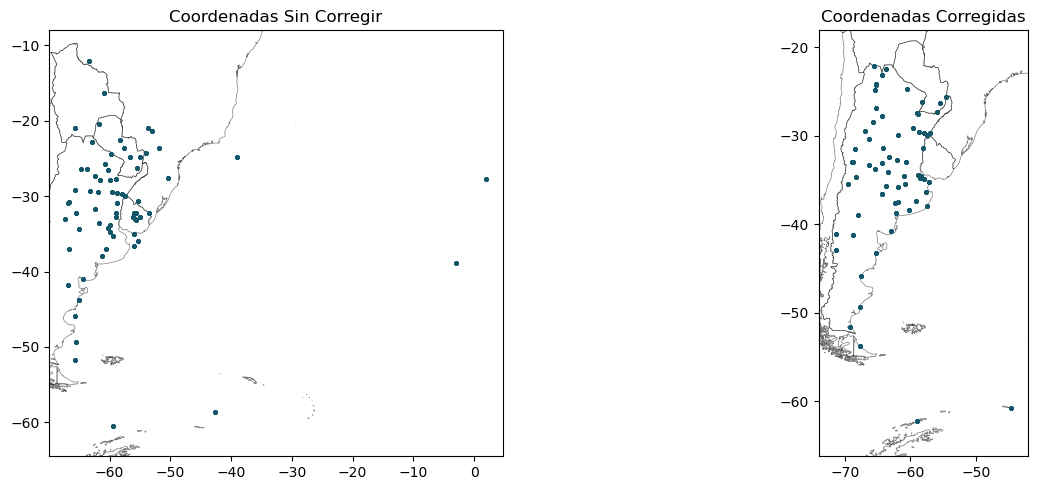

In [81]:
plot_geo_dataframes(pais, df_coords, df_original)

In [82]:
# @title
df_coords_unique = df_coords[['Estacion', 'lat', 'long']].drop_duplicates()
# Combina los DataFrames utilizando la columna 'estacion'
df_combinado = pd.merge(df_original, df_coords_unique, on='Estacion', suffixes=('', '_df1'))

# Actualiza los valores incorrectos en df con los valores correctos de df1
df_combinado['lat'] = df_combinado['lat_df1']
df_combinado['long'] = df_combinado['long_df1']

# Elimina las columnas innecesarias
df = df_combinado.iloc[:, np.r_[0:15]]



In [83]:
# @title
df_combinado.shape[0]

840

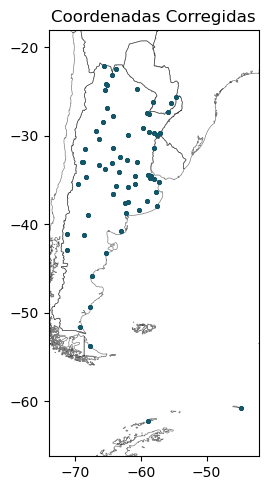

In [84]:
pais= country_boundaries
# Supongamos que tienes dos GeoDataFrames llamados gdf y gdf1


gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat']), crs='EPSG:4326')

# Crear el mapa con un solo subgráfico
fig, ax = plt.subplots(figsize=(15, 5))

# Plotear la capa de polígonos (límites del país)
pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

# Plotear la capa de puntos con colores basados en alguna columna
gdf.plot(ax=ax, color='#145769', marker='o', markersize=5)

# Ajustar los límites del gráfico
x_min, y_min, x_max, y_max = gdf.total_bounds
margin_scale = 0.1
x_range = x_max - x_min
y_range = y_max - y_min
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range
ax.set_xlim(x_min_adjusted, x_max_adjusted)
ax.set_ylim(y_min_adjusted, y_max_adjusted)

# Añadir título al gráfico
ax.set_title("Coordenadas Corregidas")

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el mapa
plt.show()

## Corrección del Dataset
- Se transformaron los campos con valores "S/D" a np_nan


In [85]:
# @title
df = df.applymap(lambda x: np.NaN if x == "S/D" else x)

## Corrección del Dataset
- Se modificaron los tipos de datos a numeric/float

In [86]:
df[["Temperatura_(C)","Temperatura_minima_(C)", "Humedad_relativa_(%)","Velocidad_del_Viento_(km/h)", "Nubosidad_total_(octavos)","Precipitacion_(mm)",
    "Frecuencia_dias_Precipitacion_>0.1_mm"]] = df[["Temperatura_(C)","Temperatura_minima_(C)", "Humedad_relativa_(%)","Velocidad_del_Viento_(km/h)",
                                                    "Nubosidad_total_(octavos)","Precipitacion_(mm)","Frecuencia_dias_Precipitacion_>0.1_mm"]].astype(float)


In [87]:
df.dtypes #tipo de dato por columna
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             840 non-null    int64  
 1   Estacion                               840 non-null    object 
 2   mes                                    840 non-null    object 
 3   lat                                    840 non-null    float64
 4   long                                   840 non-null    float64
 5   Altura_(m)                             840 non-null    int64  
 6   Numero                                 840 non-null    int64  
 7   Temperatura_(C)                        838 non-null    float64
 8   Temperatura_maxima_(C)                 840 non-null    float64
 9   Temperatura_minima_(C)                 818 non-null    float64
 10  Humedad_relativa_(%)                   812 non-null    float64
 11  Veloci

## Estadística descriptiva del Dataset

In [88]:
# @title
df.iloc[:, np.r_[7:15]].describe()

,Temperatura_(C),Temperatura_maxima_(C),Temperatura_minima_(C),Humedad_relativa_(%),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Precipitacion_(mm),Frecuencia_dias_Precipitacion_>0.1_mm
count,838.000000,840.000000,818.000000,812.000000,708.000000,826.000000,807.000000,807.000000
mean,15.871838,22.411667,10.225428,68.044581,12.456497,3.817191,69.334944,6.756877
std,6.996565,7.443672,6.775667,10.828241,5.390830,0.764862,52.093688,2.763202
min,-11.600000,-7.300000,-16.800000,30.100000,3.000000,1.400000,0.000000,0.000000
25%,11.200000,18.000000,5.525000,62.175000,8.700000,3.400000,23.400000,4.750000
50%,16.300000,23.100000,10.700000,70.200000,11.300000,3.700000,59.000000,7.100000
75%,21.700000,28.300000,15.475000,76.325000,14.800000,4.100000,108.600000,8.700000
max,27.900000,35.100000,22.300000,88.100000,30.800000,7.500000,237.000000,16.300000


### Distribución de los datos

In [181]:

def plot_boxplots(df):
    df_boxplot = df.iloc[:, np.r_[7:15]]
    columns_for_boxplot = df_boxplot.columns

    # Crear subgráficos para cada columna
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(14, 10))
    fig.suptitle("Boxplots por Columna", fontsize=16)

    # Iterar sobre las columnas y crear los boxplots
    for i, col in enumerate(columns_for_boxplot):
        row = i // 4
        col_position = i % 4  # Cambiado el nombre de la variable
        sns.boxplot(y=df_boxplot[col], ax=axs[row, col_position], orient='v', whis=1.5)  # Especifica la orientación vertical
        axs[row, col_position].set_title(col)
        axs[row, col_position].set(xlabel=None, ylabel=None)  # Eliminar etiquetas de los ejes

    # Ajustar el diseño y mostrar los gráficos
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



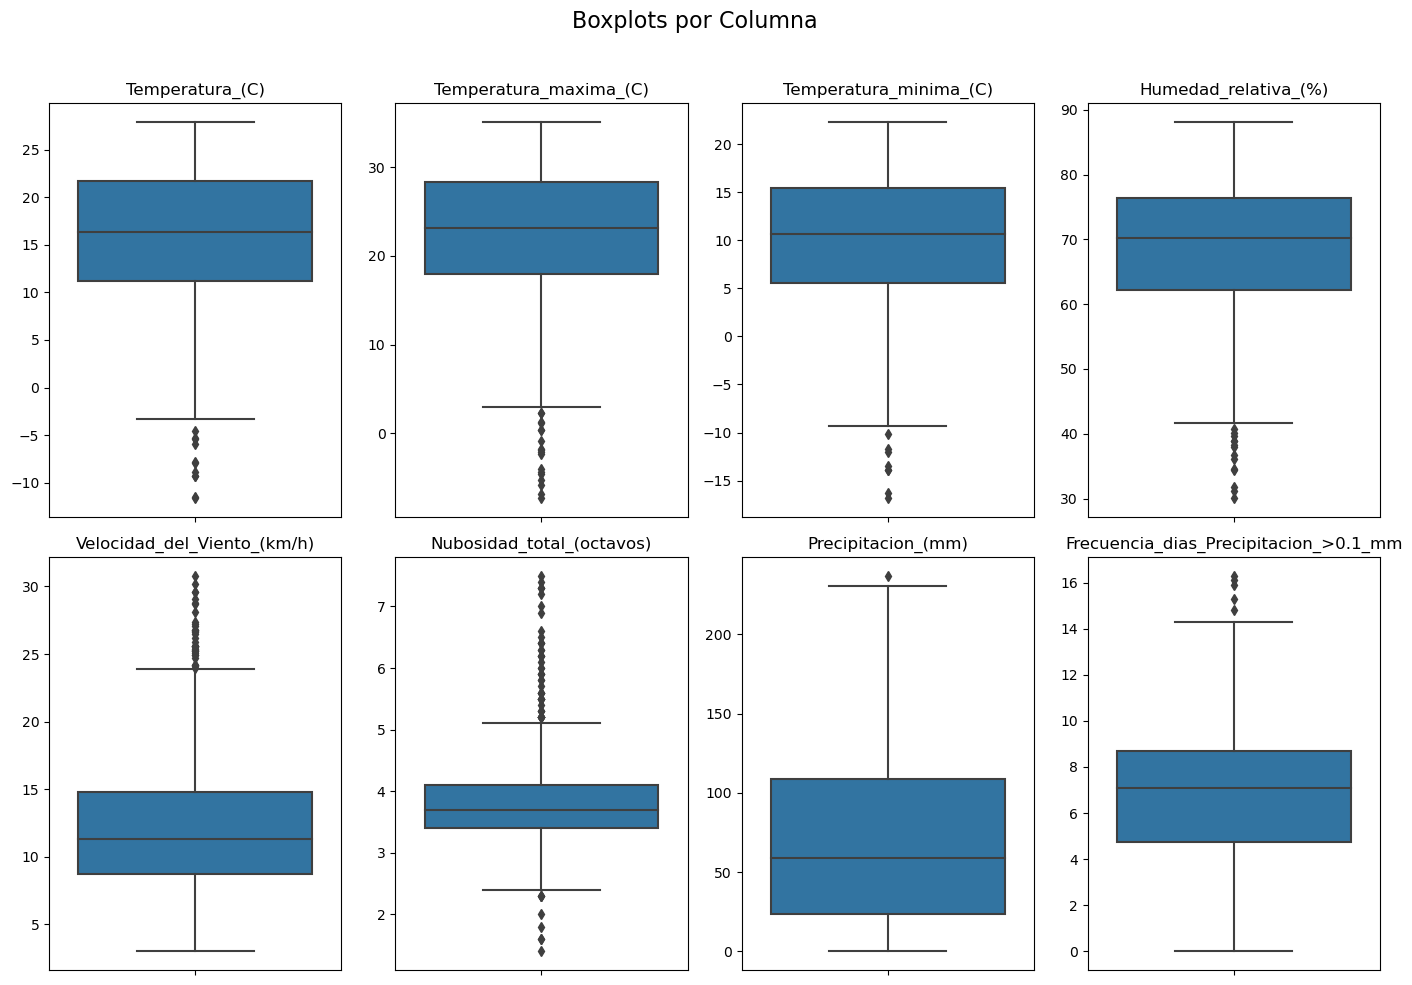

In [182]:
plot_boxplots(df)

### Porcentaje de datos por fuera de los bigotes
 Q1 − 1.5 ∗ RI y Q3 + 1.5 ∗ RI.


In [91]:
# @title
def f(row):
    if row[colname] < lower_lim:
        val = 'Es Outlier'
    elif row[colname] > upper_lim:
        val = 'Es Outlier'
    else:
        val = 'No es Outlier'
    return val

In [92]:
outliers_df = pd.DataFrame()
#type(estadisticos)
rango= np.r_[7:15]
y= 0
df_out = df
for x in rango:

    colname = df_out.columns[x]
   # print(colname)
    Q1 = df_out[colname].quantile(0.25)
    Q3 = df_out[colname].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    df_out['outlier'] = df_out.apply(f, axis=1)


    porcentaje =df_out['outlier'].value_counts(normalize=True).rename(colname)

    lower_lim_ = pd.Series({"lower_lim":lower_lim}).rename(colname)
    upper_lim_ = pd.Series({"upper_lim":upper_lim}).rename(colname)

    porcentaje= pd.concat([porcentaje, lower_lim_], axis=0)
    porcentaje= pd.concat([porcentaje, upper_lim_], axis=0)
   # porcentaje = porcentaje.append(lower_lim_).rename(colname)
   # porcentaje = porcentaje.append(upper_lim_).rename(colname)

   # print(porcentaje)
    outliers_df = pd.concat ([outliers_df,porcentaje], axis=1)
    #outliers_df = outliers_df.append(porcentaje,ignore_index=False)
    #print(outliers_df)

In [93]:
outliers_df

,Temperatura_(C),Temperatura_maxima_(C),Temperatura_minima_(C),Humedad_relativa_(%),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Precipitacion_(mm),Frecuencia_dias_Precipitacion_>0.1_mm
No es Outlier,0.986905,0.978571,0.990476,0.983333,0.958333,0.933333,0.99881,0.994048
Es Outlier,0.013095,0.021429,0.009524,0.016667,0.041667,0.066667,0.00119,0.005952
lower_lim,-4.550000,2.550000,-9.400000,40.950000,-0.450000,2.350000,-104.40000,-1.175000
upper_lim,37.450000,43.750000,30.400000,97.550000,23.950000,5.150000,236.40000,14.625000


# Localización de Outliers y No datos

In [183]:

def plot_outliers_and_nan(df):
    def detect_outlier(row):
        if row[colname] < lower_lim or row[colname] > upper_lim:
            return 'Es Outlier'
        else:
            return 'No es Outlier'

    outliers_df = pd.DataFrame()
    rango = np.r_[7:15]
    y = 0
    df_out = df.copy()

    columnas_interes = df.columns[7:15]

    # Calcular los límites ajustados con un margen del 10%
    x_min, x_max = df['long'].min(), df['long'].max()
    y_min, y_max = df['lat'].min(), df['lat'].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    margin_scale = 0.1
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    # Crear una figura y subgráficos en dos filas y cuatro columnas con ajustes de tamaño y espacio
    fig, axs = plt.subplots(2, 4, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1, 1, 1], 'wspace': 0.1})

    # Iterar sobre las columnas de interés y crear un gráfico de dispersión para cada una
    for i, col in enumerate(columnas_interes, start=1):
        row_index = (i - 1) // 4
        col_index = (i - 1) % 4

        country_boundaries.boundary.plot(ax=axs[row_index, col_index], color='black', linewidth=1, linestyle='dashed')

        colname = df_out.columns[i + 6]  # Ajustar índice
        Q1 = df_out[colname].quantile(0.25)
        Q3 = df_out[colname].quantile(0.75)
        IQR = Q3 - Q1
        lower_lim = Q1 - 1.5 * IQR
        upper_lim = Q3 + 1.5 * IQR

        df_out['outlier'] = df_out.apply(detect_outlier, axis=1)
        df_filtrado = df_out.loc[df_out['outlier'] == 'Es Outlier']

        axs[row_index, col_index].scatter(df_filtrado['long'], df_filtrado['lat'], color='red', s=40, label='Outliers')

        df_nan = df_out[df_out[colname].isna()]
        axs[row_index, col_index].scatter(df_nan['long'], df_nan['lat'], color='green', s=40, label='Nan')

        axs[row_index, col_index].set_xlim(x_min_adjusted, x_max_adjusted)
        axs[row_index, col_index].set_ylim(y_min_adjusted, y_max_adjusted)

        axs[row_index, col_index].set_title(colname)

    # Mostrar los gráficos
    plt.show()



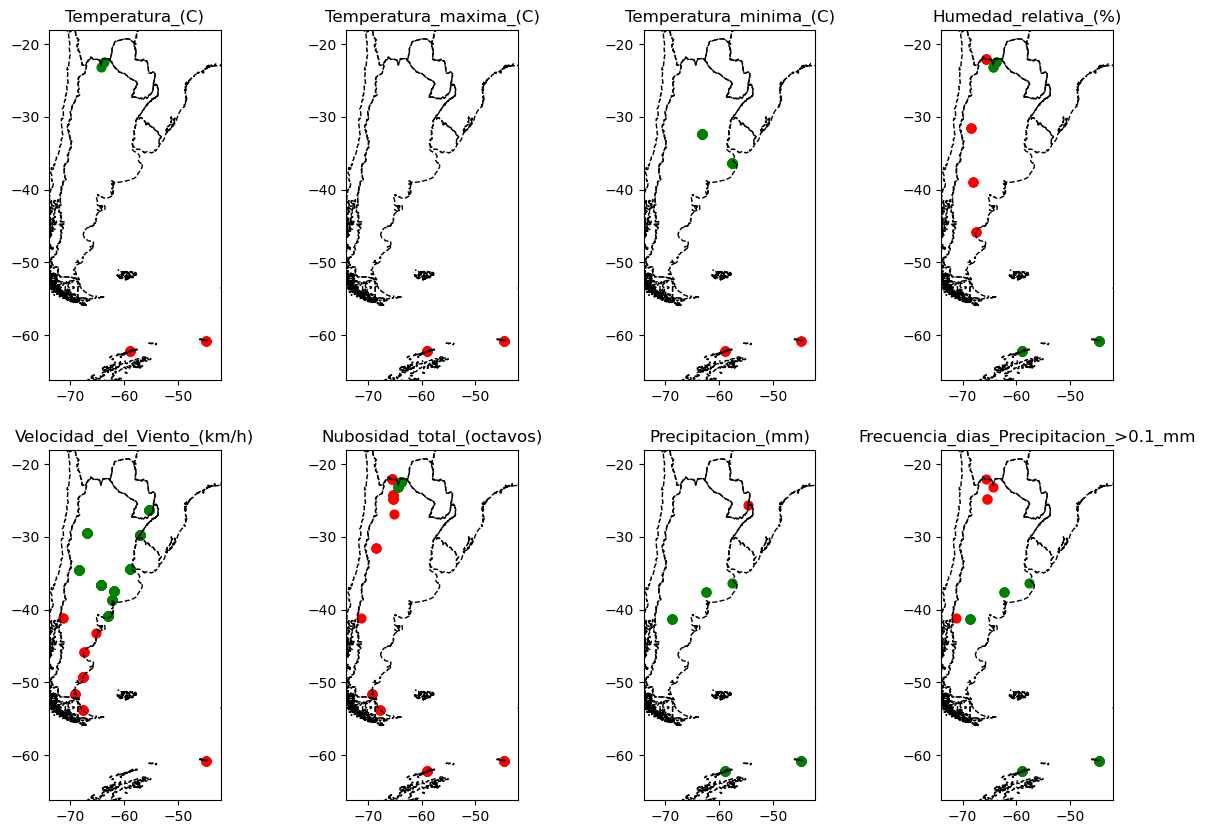

In [184]:
plot_outliers_and_nan(df)

### Tratamiento de Outliers

- se le asigno el valor de la mediana a los outliers

In [ ]:
def reemplazar_outlier_con_mediana(valor, lower_lim, upper_lim, mediana):
    if valor < lower_lim or valor > upper_lim:
        return mediana
    else:
        return valor

median_values = df.median()

# 2. Itera sobre las columnas de interés y reemplaza los outliers con la mediana
rango = np.r_[7:15]
df_median = df.copy()  # Hacemos una copia para no modificar el DataFrame original

for col_index in rango:
    col_name = df_median.columns[col_index]

    Q1 = df_median[col_name].quantile(0.25)
    Q3 = df_median[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR

    # Calcular la mediana para la columna actual
    mediana_actual = median_values[col_name]

    # Aplicar la función a toda la columna
    df_median[col_name] = df_median[col_name].apply(
        lambda x: reemplazar_outlier_con_mediana(x, lower_lim, upper_lim, mediana_actual)
    )


## Interpolación IDW


Vamos a reemplazar los valores NO DATO por el resultado de la interpolación IDW. La interpolación se va a realizar tambien en base a las medianas anuales de cada estación 

In [96]:
#Funciones para interpolar y graficar
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536>
    """

    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    # calculate hypotenuse
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """

    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)


def knn(df_coordenadas, model):
    """ K-NN
     Inputs:
     - dataframe con las coordenadas. LA lectura de las mismas
 por parte del modelo tienen la forma [[x1,y1], [x2, y2],...[xn,yn]]
     - modelo predictivo

     Outputs: predicciones del modelo a partir del modelo (valor de zi),
          a partir d elas coordenadas de cada punto de la grilla
    """
    predictions_KNN = model.predict(df_coordenadas.values)
    return predictions_KNN

def plot(x,y,z, grid, Isocontornos = None):
    """ Plot the input points and the result """
    extent = (x.min(), x.max(), y.min(), y.max() )
    plt.figure(figsize=(15,10))
    plt.imshow(grid, extent=extent, cmap='rainbow', interpolation='gaussian')

    if Isocontornos != None:
        plt.contour(grid, extent=extent, levels=Isocontornos, linewidths=1, colors='gray')
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7,s=20)
    plt.colorbar()



def plot(x, y, z, grid, Isocontornos=None, country_boundaries=None):
    """ Plot the input points, result, and country boundaries """
    extent = (x.min(), x.max(), y.min(), y.max())
    plt.figure(figsize=(15, 10))

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=extent, cmap='rainbow', interpolation='gaussian',aspect='auto')

    # Agregar isocontornos si se proporcionan
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        plt.contour(grid, extent=extent, levels=Isocontornos, linewidths=1, colors='gray')

    # Mostrar los límites del país como referencia
    if country_boundaries is not None:
        #country_boundaries.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')
    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    plt.colorbar()

In [97]:
df_filtered = df_median[['lat', 'long', 'Temperatura_(C)']].dropna()
df_filtered = df_filtered.groupby(['lat', 'long']).mean().reset_index()


y = df_filtered.lat.values
x = df_filtered.long.values
z = df_filtered['Temperatura_(C)'].values


#df_na=df_median[['lat', 'long', 'Temperatura_(C)']]
#df_na= df_na.isna().any(axis=1)


df_na = df_median[['lat', 'long', 'Temperatura_(C)']][df_median[['lat', 'long', 'Temperatura_(C)']].isna().any(axis=1)]
y_na = df_na.lat.values
x_na = df_na.long.values

In [98]:
#Armado de grilla
# size of the grid to interpolate
nx, ny = 100, 100

# generate two arrays of evenly space data between ends of
#  previous arrays
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.max(), y.min(), ny)

# generate grid
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

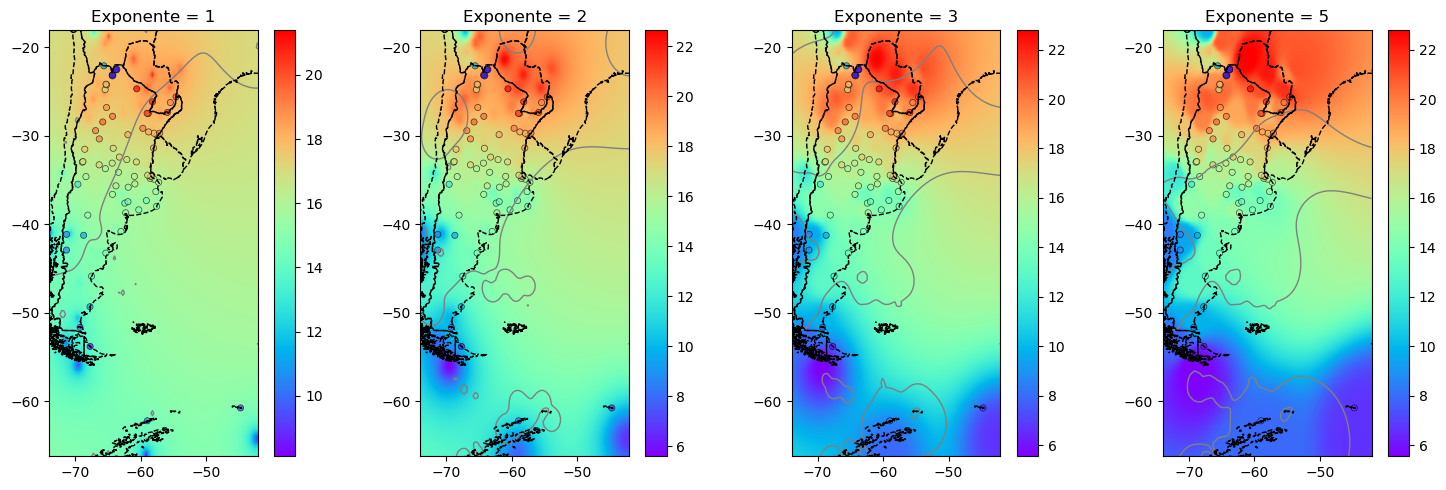

In [99]:

def plot_interpolacion(x, y, z, xi, yi, exponentes, country_boundaries=None, Isocontornos=None):
    def simple_idw(x, y, z, xi, yi, power=2):
        dists = np.hypot(x[:, np.newaxis] - xi, y[:, np.newaxis] - yi)
        weights = 1.0 / dists**power
        weights /= np.sum(weights, axis=0)
        values = np.dot(weights.T, z)
        return values

    # Crear subgráficos en una fila
    plt.figure(figsize=(15, 5))

    for i, exponente in enumerate(exponentes, 1):
        # Calcular la grilla interpolada
        grid = simple_idw(x, y, z, xi, yi, power=exponente)
        grid = grid.reshape((ny, nx))

        # Crear un subplot en la posición i
        plt.subplot(1, len(exponentes), i)

        # Calcular los límites ajustados con un margen del 10%
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        x_range = x_max - x_min
        y_range = y_max - y_min
        margin_scale = 0.1
        x_min_adjusted = x_min - margin_scale * x_range
        x_max_adjusted = x_max + margin_scale * x_range
        y_min_adjusted = y_min - margin_scale * y_range
        y_max_adjusted = y_max + margin_scale * y_range

        # Mostrar la grilla interpolada como una imagen
        plt.imshow(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
                   cmap='rainbow', interpolation='gaussian', aspect='auto')
        plt.colorbar(norm=Normalize(vmin=grid.min(), vmax=grid.max()))

        # Agregar isocontornos si se proporcionan
        if Isocontornos is not None:
            # Personalizar la apariencia de los isocontornos
            contours = plt.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
                                   levels=Isocontornos, linewidths=1, colors='gray')
            # Agregar etiquetas a los isocontornos
            #plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

        # Mostrar los límites del país como referencia sin relleno
        if country_boundaries is not None:
            country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')

        # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
        plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)
        plt.scatter(x_na, y_na,  color='blue', edgecolors='black', linewidths=0.5, alpha=0.7, s=25)

        # Ajustar los límites del eje según el bounding box ajustado con margen
        plt.xlim(x_min_adjusted, x_max_adjusted)
        plt.ylim(y_min_adjusted, y_max_adjusted)

        # Agregar un título que incluya el valor actual de exponente
        plt.title(f'Exponente = {exponente}')

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

# Uso de la función


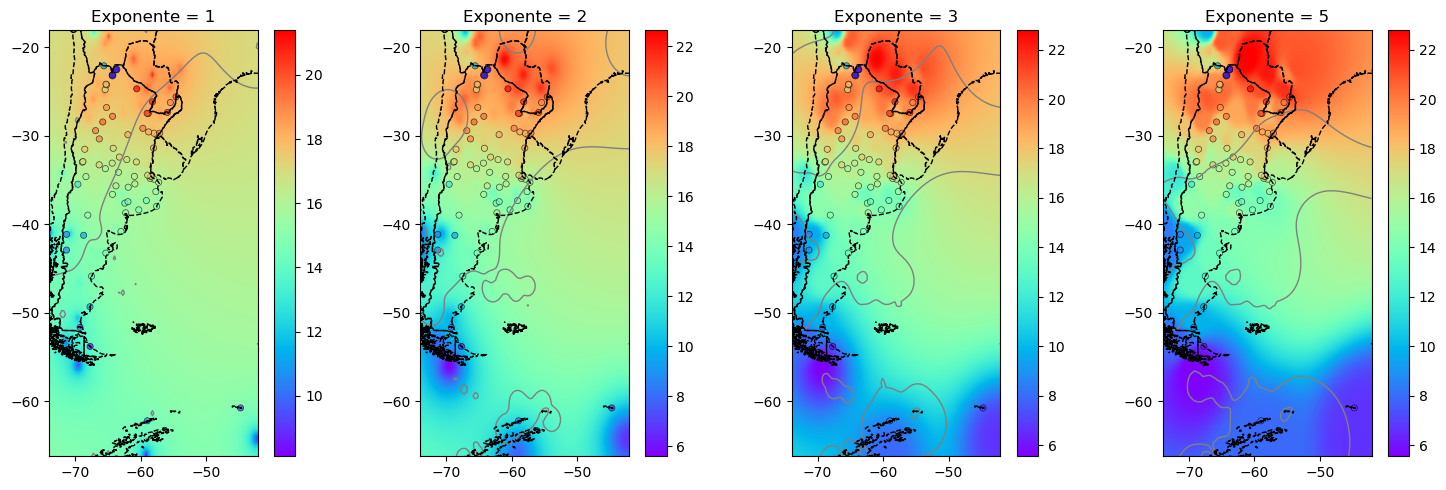

In [100]:
plot_interpolacion(x, y, z, xi, yi, exponentes, country_boundaries, Isocontornos)


Vamos a ver el gráfico con más detalle

In [101]:
def plot_with_country1(x, y, z, grid1, Isocontornos=None, country_boundaries=None, margin_scale=.1):
    """ Plot the input points, result, and country boundaries with a specified margin """


   # Obtener los límites del bounding box de los puntos
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min


    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted_grid = x_min - margin_scale * x_range
    x_max_adjusted_grid = x_max + margin_scale * x_range
    y_min_adjusted_grid = y_min - margin_scale * y_range
    y_max_adjusted_grid = y_max + margin_scale * y_range






    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x_na.min(), x_na.max()
    y_min, y_max = y_na.min(), y_na.max()

    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min


    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    plt.figure(figsize=(15, 10))

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=(x_min_adjusted_grid, x_max_adjusted_grid, y_min_adjusted_grid, y_max_adjusted_grid),
                    cmap='rainbow', interpolation='gaussian', aspect='auto')
    plt.colorbar(norm=Normalize(vmin=grid.min(), vmax=grid.max()))

    # Agregar isocontornos si se proporcionan
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        contours = plt.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
                           levels=Isocontornos, linewidths=1, colors='gray')
        # Agregar etiquetas a los isocontornos
        plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    #plt.colorbar()

    # Ajustar los límites del eje según el bounding box ajustado con margen
    plt.xlim(x_min_adjusted, x_max_adjusted)
    plt.ylim(y_min_adjusted, y_max_adjusted)

    # Quitar etiquetas de los ejes x e y
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlabel('')
    #ax.set_ylabel('')


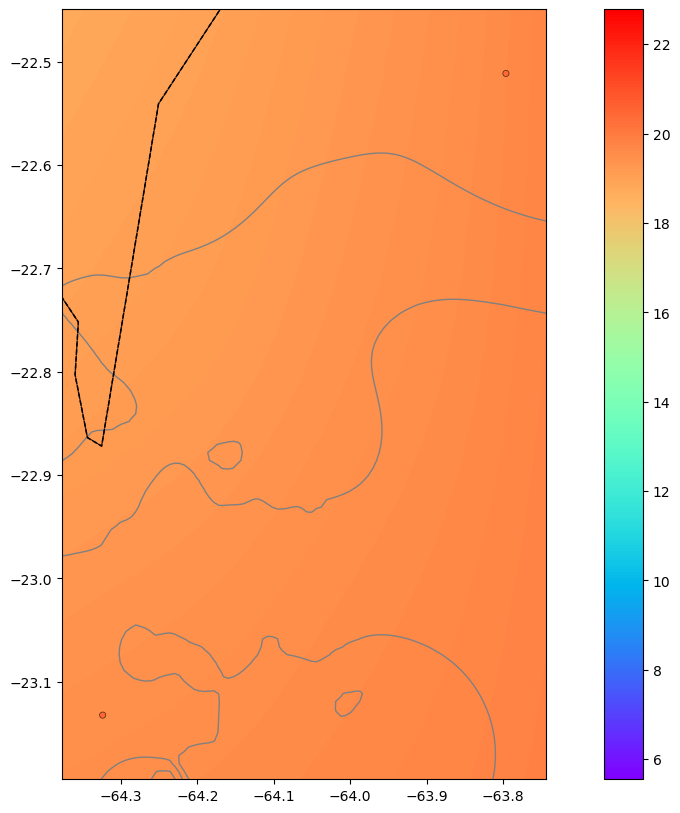

In [102]:
_exponente = 10
grid1 = simple_idw(x,y,z,xi,yi, power = exponente )
grid1 = grid1.reshape((ny, nx))
plot_with_country1(x, y, z, grid1, Isocontornos=[-10,-5,0,5, 10,15, 20,25,30, 35], country_boundaries=country_boundaries, margin_scale=0.1)
plt.show()

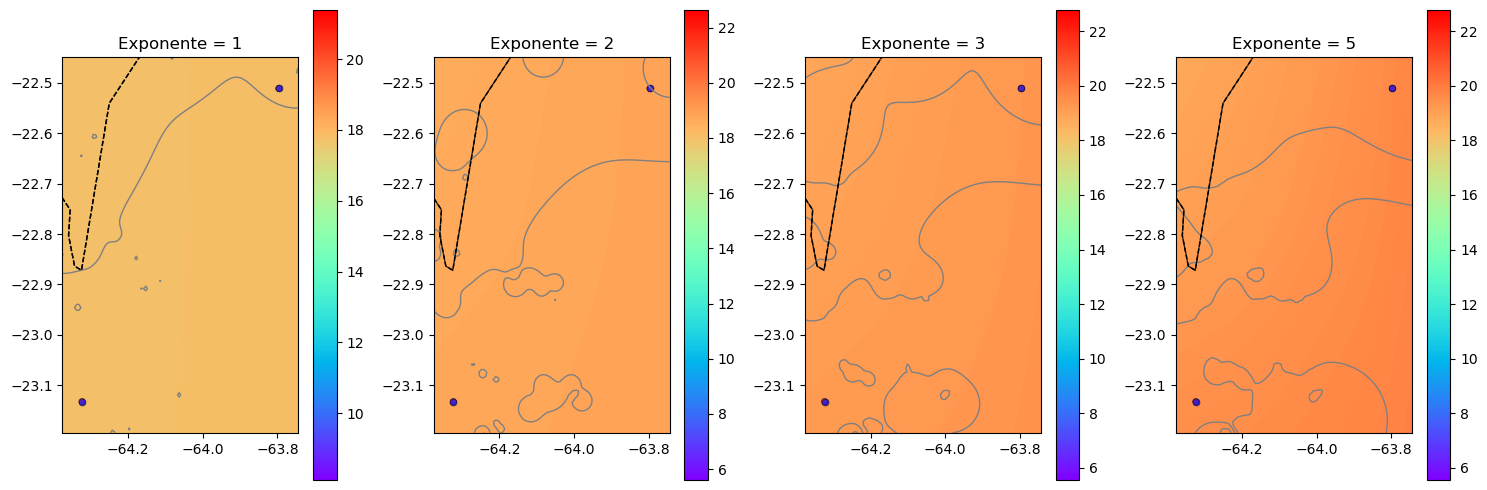

In [103]:
# Definir los diferentes valores de exponente
exponentes = [1,2,3,5]

# Crear subgráficos en una fila
plt.figure(figsize=(15, 5))

for i, exponente in enumerate(exponentes, 1):
    # Calcular la grilla interpolada
    grid = simple_idw(x, y, z, xi, yi, power=exponente)
    grid = grid.reshape((ny, nx))

    # Crear un subplot en la posición i
    plt.subplot(1, len(exponentes), i)

    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min


    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted_grid = x_min - margin_scale * x_range
    x_max_adjusted_grid = x_max + margin_scale * x_range
    y_min_adjusted_grid = y_min - margin_scale * y_range
    y_max_adjusted_grid = y_max + margin_scale * y_range

    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x_na.min(), x_na.max()
    y_min, y_max = y_na.min(), y_na.max()

    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min


    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=(x_min_adjusted_grid, x_max_adjusted_grid, y_min_adjusted_grid, y_max_adjusted_grid),
               cmap='rainbow', interpolation='gaussian', aspect='auto')
    plt.colorbar(norm=Normalize(vmin=grid.min(), vmax=grid.max()))

    # Agregar isocontornos si se proporcionan
    Isocontornos = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35]
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        contours = plt.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
                               levels=Isocontornos, linewidths=1, colors='gray')
        # Agregar etiquetas a los isocontornos
        plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)
    plt.scatter(x_na, y_na,  color='blue', edgecolors='black', linewidths=0.5, alpha=0.7, s=25)

    # Agregar una barra de color para la escala de colores
    #plt.colorbar()

    # Ajustar los límites del eje según el bounding box ajustado con margen
    plt.xlim(x_min_adjusted, x_max_adjusted)
    plt.ylim(y_min_adjusted, y_max_adjusted)

    # Agregar un título que incluya el valor actual de exponente
    plt.title(f'Exponente = {exponente}')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Utilizando el método IDW vemos que al aumentar el exponente aumenta el contraste en la representaciòn de la grilla. Es decir, con valores más altos de exponente la distribución de los valores tiene mayor varianza

Para pasar de grilla a raster

In [104]:
# @title
# Transformo la grilla a Raster

from shapely.geometry import box
# Definir las coordenadas extremas
    # Calcular los límites ajustados con un margen del 10%
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
x_range = x_max - x_min
y_range = y_max - y_min
margin_scale = 0.1
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range

xmin, xmax, ymin, ymax = x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted

# Crear un GeoDataFrame ficticio con una geometría de tipo caja que cubre el área de interés
geometry = box(xmin, ymin, xmax, ymax)
gdf = gpd.GeoDataFrame(geometry=[geometry])

# Obtener el sistema de referencia espacial del GeoDataFrame
desired_crs = 'EPSG:4326'

# Ancho y alto del raster
width = grid.shape[1]
height = grid.shape[0]

# Establecer la resolución del raster
res = (width / grid.shape[1], height / grid.shape[0])

# Crear un objeto de transformación para definir la relación entre las coordenadas del mundo y los píxeles del raster
transform = from_origin(x_min_adjusted, y_max_adjusted, res[0], res[1])

# Definir el perfil del raster
profile = {
    'driver': 'GTiff',
    'count': 1,  # Número de bandas
    'dtype': 'float32',  # Tipo de datos
    'width': width,  # Ancho del raster
    'height': height,  # Altura del raster
    'crs': desired_crs,  # Sistema de referencia espacial
    'transform': transform,  # Transformación
    'compress': 'lzw',  # Compresión
    'nodata': -9999,  # Valor para los nodata
}

# Escribir el raster en un archivo GeoTIFF
#output_file = '/content/drive/My Drive/datasets_colab/final/raster.tif'
output_file = 'raster.tif'

with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(grid, 1)

# Crear una máscara de geometría válida
#mask = geometry_mask(gdf.geometry, transform=dst.transform, out_shape=(dst.height, dst.width), invert=True)

# Aplicar la máscara al raster
#grid1_masked = np.ma.array(grid, mask=mask)

# Escribir el nuevo raster con la máscara aplicada
#output_masked_file = '/content/drive/My Drive/datasets_colab/final/raster_masked.tif'
#with rasterio.open(output_masked_file, 'w', **profile) as dest:
#    dest.write(grid1_masked, 1)

Para interpolar puntos con raster

In [105]:
df_median.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             840 non-null    int64  
 1   Estacion                               840 non-null    object 
 2   mes                                    840 non-null    object 
 3   lat                                    840 non-null    float64
 4   long                                   840 non-null    float64
 5   Altura_(m)                             840 non-null    int64  
 6   Numero                                 840 non-null    int64  
 7   Temperatura_(C)                        838 non-null    float64
 8   Temperatura_maxima_(C)                 840 non-null    float64
 9   Temperatura_minima_(C)                 818 non-null    float64
 10  Humedad_relativa_(%)                   812 non-null    float64
 11  Veloci

In [106]:
from shapely.geometry import Point

gdf_median = gpd.GeoDataFrame(df_median, geometry=gpd.points_from_xy(df_median['long'], df_median['lat']), crs='EPSG:4326')

def raster_values_at_points(raster_path, points_gdf: gpd.GeoDataFrame, column_name: str) -> gpd.GeoDataFrame:
    new_gdf = points_gdf.copy()  # do not change the original GeoDataFrame

    # Extracting coordinates from the GeoSeries
    coords = [(point.x, point.y) for point in points_gdf.geometry]

    with rasterio.open(raster_path) as src:
        # Sample raster values at coordinates
        new_gdf[column_name] = [x[0] for x in src.sample(coords)]

    return new_gdf

# Example usage
raster_path = 'raster.tif'
points_gdf = gdf_median

raster_values_gdf = raster_values_at_points(raster_path, points_gdf, "rastervalue")
print(raster_values_gdf.head())

   Unnamed: 0   Estacion    mes        lat       long  Altura_(m)  Numero  \
0           0  LA QUIACA    ene -22.107729 -65.604696        3459   87007   
1           1  LA QUIACA    feb -22.107729 -65.604696        3459   87007   
2           2  LA QUIACA    mar -22.107729 -65.604696        3459   87007   
3           3  LA QUIACA  abril -22.107729 -65.604696        3459   87007   
4           4  LA QUIACA   mayo -22.107729 -65.604696        3459   87007   

   Temperatura_(C)  Temperatura_maxima_(C)  Temperatura_minima_(C)  \
0             12.8                    20.1                     7.4   
1             12.5                    19.9                     7.0   
2             12.4                    19.9                     6.3   
3             10.9                    19.7                     2.8   
4              6.9                    17.3                    -3.0   

   Humedad_relativa_(%)  Velocidad_del_Viento_(km/h)  \
0                  65.3                          6.9   
1   

Por último vamos a asignarle los valores interpolados a los nan.

In [107]:
# @title
raster_values_gdf['Temperatura_(C)'] = np.where(np.isnan(raster_values_gdf['Temperatura_(C)']),
                                                 raster_values_gdf['rastervalue'],
                                                 raster_values_gdf['Temperatura_(C)'])
raster_values_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Unnamed: 0                             840 non-null    int64   
 1   Estacion                               840 non-null    object  
 2   mes                                    840 non-null    object  
 3   lat                                    840 non-null    float64 
 4   long                                   840 non-null    float64 
 5   Altura_(m)                             840 non-null    int64   
 6   Numero                                 840 non-null    int64   
 7   Temperatura_(C)                        840 non-null    float64 
 8   Temperatura_maxima_(C)                 840 non-null    float64 
 9   Temperatura_minima_(C)                 818 non-null    float64 
 10  Humedad_relativa_(%)                   812 non-null   

Ahora hacemos un loop para todos los campos: primero la función y despues el loop. vamos a guardar un shape con todos los resultados

In [108]:
# @title
#################################################
#################################################
### Interpolar
#################################################
#################################################

# Read points from shapefile


def raster_values_at_points(raster_path, points_gdf: gpd.GeoDataFrame, column_name: str) -> gpd.GeoDataFrame:
    new_gdf = points_gdf.copy()  # do not change the original GeoDataFrame

    # Extracting coordinates from the GeoSeries
    coords = [(point.x, point.y) for point in points_gdf.geometry]

    with rasterio.open(raster_path) as src:
        # Sample raster values at coordinates
        new_gdf[column_name] = [x[0] for x in src.sample(coords)]

    return new_gdf


rango = np.r_[7:15]

for x in rango:
    colname = df_median.columns[x]
    sanitized_colname = colname.replace('(', '').replace(')', '').replace('/', '_')
#    output_file = f'/content/drive/My Drive/datasets_colab/final/r_{sanitized_colname}.tif'
    output_file = f'r_{sanitized_colname}.tif'

    print(f"Intentando crear: {output_file}")
    try:
        with rasterio.open(output_file, 'w', **profile) as dst:
            # Puedes opcionalmente escribir datos en el raster si es necesario
            data = np.zeros((height, width), dtype=np.float32)
            dst.write(data, 1)
        print(f"Archivo creado exitosamente: {output_file}")
    except Exception as e:
        print(f"Error al crear el archivo: {e}")



Intentando crear: r_Temperatura_C.tif
Archivo creado exitosamente: r_Temperatura_C.tif
Intentando crear: r_Temperatura_maxima_C.tif
Archivo creado exitosamente: r_Temperatura_maxima_C.tif
Intentando crear: r_Temperatura_minima_C.tif
Archivo creado exitosamente: r_Temperatura_minima_C.tif
Intentando crear: r_Humedad_relativa_%.tif
Archivo creado exitosamente: r_Humedad_relativa_%.tif
Intentando crear: r_Velocidad_del_Viento_km_h.tif
Archivo creado exitosamente: r_Velocidad_del_Viento_km_h.tif
Intentando crear: r_Nubosidad_total_octavos.tif
Archivo creado exitosamente: r_Nubosidad_total_octavos.tif
Intentando crear: r_Precipitacion_mm.tif
Archivo creado exitosamente: r_Precipitacion_mm.tif
Intentando crear: r_Frecuencia_dias_Precipitacion_>0.1_mm.tif
Archivo creado exitosamente: r_Frecuencia_dias_Precipitacion_>0.1_mm.tif


In [109]:
# @title
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from shapely.geometry import box

gdf_median = gpd.GeoDataFrame(df_median, geometry=gpd.points_from_xy(df_median['long'], df_median['lat']), crs='EPSG:4326')

#Itera en este rango de columnas
rango = np.r_[7:15]

#Creo en GDF solo para la interpolación
coord_columns = ['geometry']  # Agrega más columnas si es necesario

# Crear un nuevo GeoDataFrame solo con las columnas de coordenadas
gdf_coords = gdf_median[coord_columns].copy()
gdf_coords_entero = gdf_coords.copy()

df_idw = df_median
final = df_median
rango_n = ['a','b','c','d','e','f','g','h',]
yy=0

for x in rango:
    colname = df_idw.columns[x]
    df_filtered = df_idw[['lat', 'long', colname]].dropna()
    df_filtered = df_filtered.groupby(['lat', 'long']).mean().reset_index()

    y = df_filtered.lat.values
    x = df_filtered.long.values
    z = df_filtered[colname].values

    nx, ny = 100, 100
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.max(), y.min(), ny)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()

    exponente = 3
    grid = simple_idw(x, y, z, xi, yi, power=exponente)
    grid = grid.reshape((ny, nx))

    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    margin_scale = 0.1
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    xmin, xmax, ymin, ymax = x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted
    geometry = box(xmin, ymin, xmax, ymax)
    gdf = gpd.GeoDataFrame(geometry=[geometry])


    # Obtener el sistema de referencia espacial del GeoDataFrame
    desired_crs = 'EPSG:4326'

    # Ancho y alto del raster
    width = grid.shape[1]
    height = grid.shape[0]

    # Establecer la resolución del raster
    res = (width / grid.shape[1], height / grid.shape[0])

    # Crear un objeto de transformación para definir la relación entre las coordenadas del mundo y los píxeles del raster
    transform = from_origin(x_min_adjusted, y_max_adjusted, res[0], res[1])

    # Definir el perfil del raster
    profile = {
        'driver': 'GTiff',
        'count': 1,  # Número de bandas
        'dtype': 'float32',  # Tipo de datos
        'width': width,  # Ancho del raster
        'height': height,  # Altura del raster
        'crs': desired_crs,  # Sistema de referencia espacial
        'transform': transform,  # Transformación
        'compress': 'lzw',  # Compresión
        'nodata': -9999,  # Valor para los nodata
    }

#    patio = '/content/drive/My Drive/datasets_colab/final/r_'
    patio = 'r_'

    colname
    formato='.tif'

    # Escribir el raster en un archivo GeoTIFF

    #colname = df_median.columns[x]
    sanitized_colname = colname.replace('(', '').replace(')', '').replace('/', '_')
#    output_file = f'/content/drive/My Drive/datasets_colab/final/r_{sanitized_colname}.tif'
    output_file = f'r_{sanitized_colname}.tif'

    with rasterio.open(output_file, 'w', **profile) as dst:
         # Puedes opcionalmente escribir datos en el raster si es necesario
             data = np.zeros((height, width), dtype=np.float32)
             dst.write(grid, 1)


    #output_file = patio+colname+formato
    #with rasterio.open(output_file, 'w', **profile) as dst:
    #  dst.write(grid, 1)



    #output_directory = '/content/drive/My Drive/datasets_colab/final/'
    #format = '.tif'
    raster_path = output_file
    print(raster_path)

    gdf_coords = raster_values_at_points(raster_path, gdf_median, 'raster_value')
    #gdf_coords_entero= pd.merge(gdf_coords_entero,gdf_coords,left_index=True, right_index=True)
    gdf_coords[colname] = np.where(np.isnan(gdf_coords[colname]),
                                           gdf_coords['raster_value'],
                                           gdf_coords[colname])



    # Asegúrate de que los índices coincidan correctamente (en este caso, estamos utilizando 'ID')
    gdf_median.set_index(gdf_median.index, inplace=True)
    gdf_coords.set_index(gdf_coords.index, inplace=True)

    # Reemplazar la columna 'Nombre' en df1 con la columna 'Nueva_Columna' de df2
    gdf_median[colname] = gdf_coords[colname]


# Especifica la ruta y el nombre del archivo Shapefile de salida
#output_shapefile = '/content/drive/My Drive/datasets_colab/final/gdf_median.gpkg'
output_shapefile = 'gdf_median.gpkg'

# Exporta el GeoDataFrame a Shapefile
gdf_median.to_file(output_shapefile)

r_Temperatura_C.tif
r_Temperatura_maxima_C.tif
r_Temperatura_minima_C.tif
r_Humedad_relativa_%.tif
r_Velocidad_del_Viento_km_h.tif
r_Nubosidad_total_octavos.tif
r_Precipitacion_mm.tif
r_Frecuencia_dias_Precipitacion_>0.1_mm.tif


In [110]:
gdf_median.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Unnamed: 0                             840 non-null    int64   
 1   Estacion                               840 non-null    object  
 2   mes                                    840 non-null    object  
 3   lat                                    840 non-null    float64 
 4   long                                   840 non-null    float64 
 5   Altura_(m)                             840 non-null    int64   
 6   Numero                                 840 non-null    int64   
 7   Temperatura_(C)                        840 non-null    float64 
 8   Temperatura_maxima_(C)                 840 non-null    float64 
 9   Temperatura_minima_(C)                 840 non-null    float64 
 10  Humedad_relativa_(%)                   840 non-null   

### Interpolación KNN

Con el dataset ya interpolado, vamos a hacer un modelo KNN para estimar valores de nuevas estaciones en donde no tenemos información. 

- Se separó el dataset en 20% 80%
- Se fueron haciendo varias pruebas de la cantidad de vecinos para ver cuales dan mejores resultados

- Finalmente el valor elegido fue de k= 1

In [186]:
############################################
#
#     Tomamos la "Temperatura# como ejemplo
#
################################################


df_filtered = df_median.groupby(['lat', 'long']).mean().reset_index()

df_filtered = df_filtered[['lat', 'long', 'Temperatura_(C)']].dropna()


coords_temp = df_filtered[['long','lat']].values
value_temp = df_filtered['Temperatura_(C)'].values

############################################
#
#     Separamos en train y test los datos
#
################################################

X_train, X_test, y_train, y_test = train_test_split(coords_temp, value_temp, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit only on X_train

# Scale both X_train and X_test
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)


/tmp/ipykernel_135741/3945576120.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_filtered = df_median.groupby(['lat', 'long']).mean().reset_index()


In [191]:
############################################
#
#  - Definimos la cantidsd de vecinos
#  - Inicializamos el modelo KNN (del tipo regresiòn)
#
################################################
neighbors = 1

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=neighbors, weights= 'distance')
regressor.fit(X_train, y_train)



y_pred = regressor.predict(X_test)



############################################
#
#  - Ajustamos el modelo con los datos de entrenamiento "train"
#
#
################################################
#knn_regressor.fit(coords_temp_train, value_temp_train)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
reg_score=regressor.score(X_test, y_test)

In [192]:
def print_regression_metrics(mae, mse, rmse, reg_score):
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2 Score: {reg_score}')

In [193]:
print_regression_metrics(mae, mse, rmse, reg_score)

MAE: 0.9228354978354982
MSE: 1.514790518824611
RMSE: 1.2307682636567336
R2 Score: 0.9042589565696563


In [ ]:
El valor de r2 0.90 da cuenta de que el modelo tiene buen rendimiento

In [208]:
error = []
k_range = range(1, 40)

# Calculating MAE error for K values between 1 and 39
for i in range(1, 40):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    mae = mean_absolute_error(y_test, pred_i)
    error.append(mae)

error_values=error

In [209]:
def plot_error_vs_k(k_range, error_values):
    plt.figure(figsize=(12, 6))
    plt.plot(k_range, error_values, color='red',
             linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)

    plt.title('K Value MAE')
    plt.xlabel('K Value')
    plt.ylabel('Mean Absolute Error')
    plt.show()

# Uso de la función
# Supongamos que tienes el rango de K en k_range y los errores correspondientes en error_values



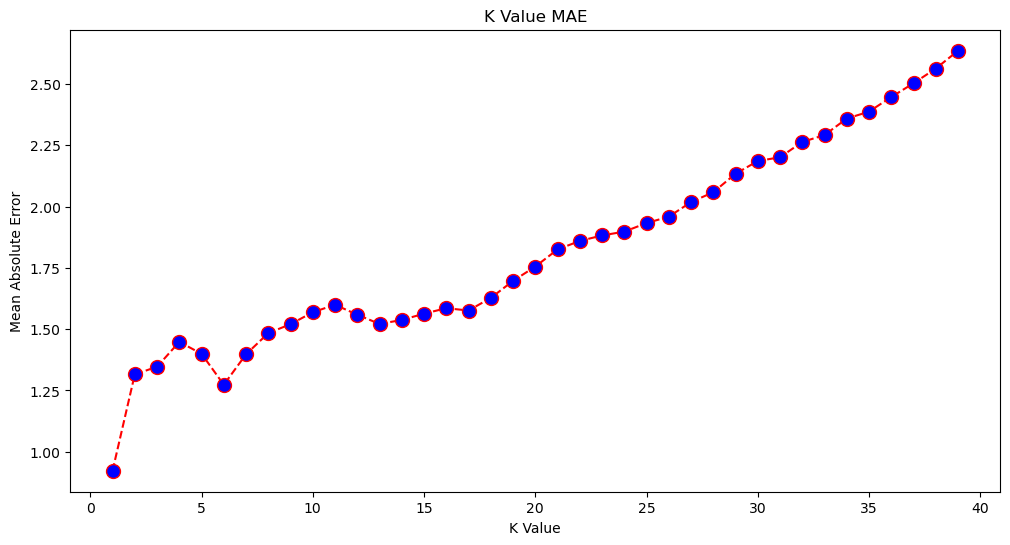

In [210]:
plot_error_vs_k(k_range, error)

Text(0, 0.5, 'Mean Absolute Error')

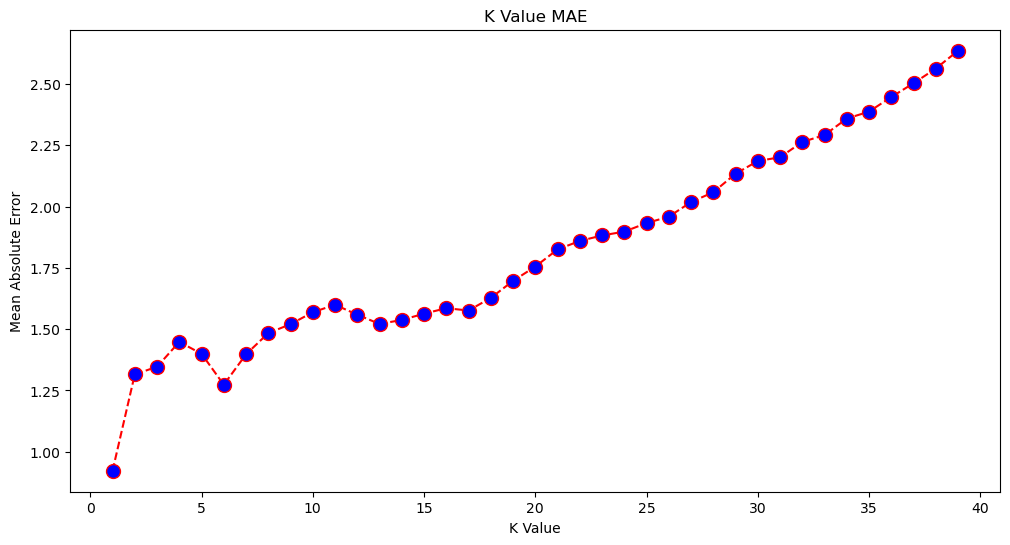

In [199]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red',
         linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)

plt.title('K Value MAE')
plt.xlabel('K Value')
plt.ylabel('Mean Absolute Error')

Text(0, 0.5, 'Mean Absolute Error')

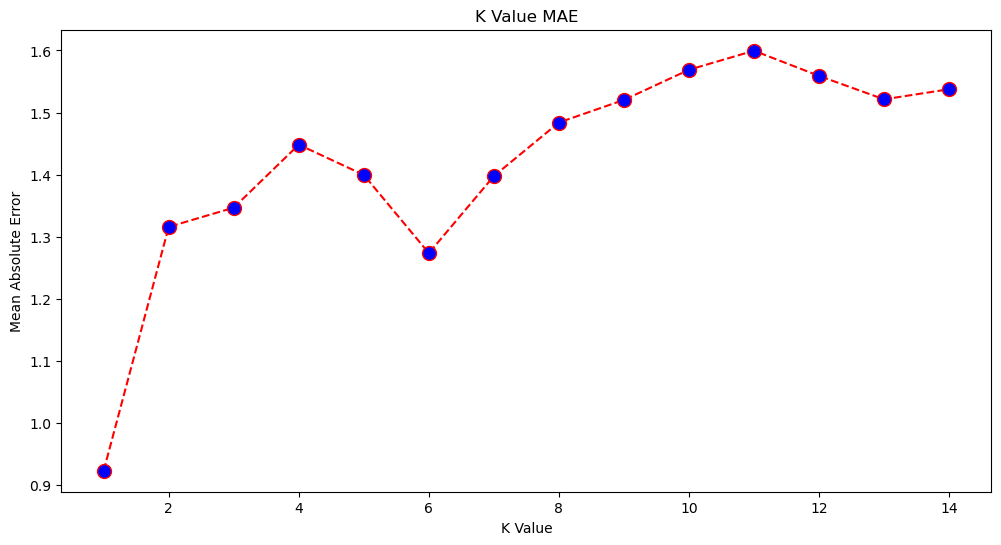

In [116]:
# @title
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), error[:14], color='red',
         linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('K Value MAE')
plt.xlabel('K Value')
plt.ylabel('Mean Absolute Error')

En los gráficos se puede observar que el valor óptimo es 1

Fuente https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

In [214]:
 
############################################
#
#  - Definimos la cantidsd de vecinos
#  - Inicializamos el modelo KNN (del tipo regresiòn)
#
################################################
neighbors = 1

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=neighbors, weights= 'distance')
regressor.fit(X_train, y_train)



y_pred = regressor.predict(X_test)



############################################
#
#  - Ajustamos el modelo con los datos de entrenamiento "train"
#
#
################################################
#knn_regressor.fit(coords_temp_train, value_temp_train)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
reg_score=regressor.score(X_test, y_test)

In [118]:
print('Métricas utilizando k=1')
print("KNN out-of-sample r-squared: {}".format(round(reg_score, 2)))
print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'reg score: {reg_score}')

Métricas utilizando k=1
KNN out-of-sample r-squared: 0.84
mae: 2.6353743478743477
mse: 2.580916253240923
rmse: 1.6065230322783808
reg score: 0.8368753883650168


In [119]:
isocontornos_comunes = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35]
isocontornos = [-20,-15,-10, -5, 0, 5,7.5, 10,12.5, 15,17.5,20,22.5,25,27.5, 30, 35]
isocontornos_invertidos = isocontornos[::-1]
def plot_with_country_knn(x, y, z, grid, Isocontornos=None, country_boundaries=None, margin_scale=0.1, ax=None):
    """ Plot the input points, result, and country boundaries with a specified margin """

    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min

    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    # Mostrar la grilla interpolada como una imagen en el eje especificado (ax)
    im = ax.imshow(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), cmap='rainbow', interpolation='gaussian', aspect='auto')

    # Agregar isocontornos si se proporcionan en el eje especificado (ax)

    if Isocontornos is not None:
        contours = ax.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), levels=Isocontornos, linewidths=.5, colors='black')
        #ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=ax, color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    scatter = ax.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=15)

    # Agregar una barra de color para la escala de colores
    plt.colorbar(scatter, ax=ax)

    # Ajustar los límites del eje según el bounding box ajustado con margen
    ax.set_xlim(x_min_adjusted, x_max_adjusted)
    ax.set_ylim(y_min_adjusted, y_max_adjusted)

    # Quitar etiquetas de los ejes x e y
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

In [120]:
#Grilla
# size of the grid to interpolate
nx, ny = 100, 100

# generate two arrays of evenly space data between ends of
#  previous arrays
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.max(), y.min(), ny)

# generate grid
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

In [121]:
# @title
def knn(df_coordenadas, model):
    """ K-NN
     Inputs:
     - dataframe con las coordenadas. LA lectura de las mismas
 por parte del modelo tienen la forma [[x1,y1], [x2, y2],...[xn,yn]]
     - modelo predictivo

     Outputs: predicciones del modelo a partir del modelo (valor de zi),
          a partir d elas coordenadas de cada punto de la grilla
    """
    predictions_KNN = model.predict(df_coordenadas.values)
    return predictions_KNN

In [122]:
neighbors_values = 1  # Puedes ajustar estos valores según sea necesario

x_knn = df_filtered['long'].values
y_knn = df_filtered['lat'].values
z_knn = df_filtered['Temperatura_(C)'].values

dfC= pd.DataFrame(columns = ['x','y'])
dfC['x'] = xi
dfC['y'] = yi


# Genera el grid interpolado con el modelo KNN
grid2 = knn(dfC, regressor)
grid2 = grid1.reshape((ny, nx))

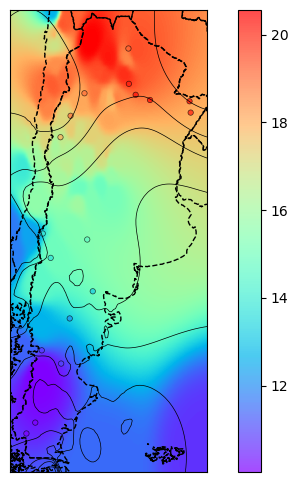

In [217]:
fig, ax = plt.subplots()
plot_with_country_knn(x_knn, y_knn, z_knn, grid2, Isocontornos=isocontornos,
                       country_boundaries=country_boundaries, margin_scale=0.1,ax=ax)
fig.set_size_inches(8, 6)
plt.show()

In [124]:
#nuevas_estaciones = gpd.read_file('/content/drive/My Drive/datasets_colab/final/nuevas_estaciones_knn.gpkg')
nuevas_estaciones = gpd.read_file('nuevas_estaciones_knn.gpkg')

nuevas_estaciones_filtered = nuevas_estaciones[['lat', 'long', 'Temperatura_(C)']]#
coords_temp = nuevas_estaciones_filtered[['long','lat']].values
value_temp = nuevas_estaciones_filtered['Temperatura_(C)'].values

y_pred=regressor.predict(coords_temp)


x_knn=nuevas_estaciones_filtered[['long']].values
y_knn=nuevas_estaciones_filtered[['lat']].values
z_knn=y_pred

### Inteporlación sobre nuevas estaciones

In [ ]:
A continuación se muestra la aplicación del modelo para nuevas estaciones en donde no hay dato

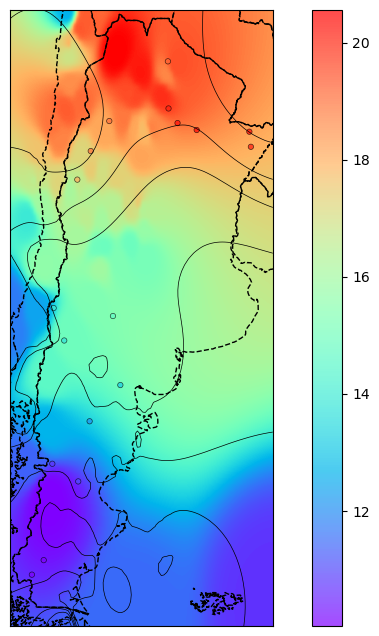

In [218]:
fig, ax = plt.subplots()
plot_with_country_knn(x_knn, y_knn, z_knn, grid1, Isocontornos=isocontornos,
                       country_boundaries=country_boundaries, margin_scale=0.1,ax=ax)
fig.set_size_inches(10, 8)
plt.show()

In [ ]:
nuevas_estaciones_filtered.head()

In [ ]:
nuevas_estaciones_filtered['Temperatura_(C)']=z_knn
nuevas_estaciones_filtered

## Cluster Jerárquico

Vamos a realizar análisis de cluster para ver si podemos agrupar las estaciones en "zonas climatológicas"
Las variables utilizadas son: Temperatura, Velocidad del Viento y Nubosidad Total

In [140]:
# @title
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram

variables_clustering = gdf_median.groupby('Estacion')[['Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)',
                                               'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)',
                                               'Nubosidad_total_(octavos)', 'Precipitacion_(mm)',
                                               'Frecuencia_dias_Precipitacion_>0.1_mm']]

# Puedes realizar operaciones de agregación o análisis en los grupos si es necesario
# Por ejemplo, calcular la media de cada columna para cada estación
variables_clustering = variables_clustering.median()



variables_clustering = variables_clustering[['Temperatura_(C)', 'Velocidad_del_Viento_(km/h)',
                                             'Nubosidad_total_(octavos)']]


normalized_data = (variables_clustering - variables_clustering.mean()) / variables_clustering.std()


# Realizar clustering jerárquico
Z_single = linkage(normalized_data, method='single', metric='euclidean')
Z_complete = linkage(normalized_data, method='complete', metric='euclidean')
Z_average = linkage(normalized_data, method='average', metric='euclidean')

# Obtener asignaciones de clusters
num_clusters = 18
clusters_single = fcluster(Z_single, num_clusters, criterion='maxclust')
clusters_complete = fcluster(Z_complete, num_clusters, criterion='maxclust')
clusters_average = fcluster(Z_average, num_clusters, criterion='maxclust')


# Calcular las distancias entre los puntos (puedes ajustar la métrica según tus necesidades)
distances = pdist(normalized_data, metric='euclidean')

# Convertir las distancias a una matriz cuadrada
distance_matrix = squareform(distances)

# Calcular el enlace para el dendrograma
linkage_matrix = linkage(distance_matrix, method='average')
#linkage_matrix =Z_average

np.random.seed(42)
num_clusters = 20

/tmp/ipykernel_135741/2224050132.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


In [136]:

def plot_dendrogram(linkage_matrix, data_index, figsize=(12, 8), leaf_rotation=90, leaf_font_size=8, title='Dendrograma para Clustering Jerárquico'):
    plt.figure(figsize=figsize)
    dendrogram(linkage_matrix, labels=data_index, orientation='top', leaf_rotation=leaf_rotation, leaf_font_size=leaf_font_size)
    plt.title(title)
    plt.xlabel('Índice de Datos')
    plt.ylabel('Distancia')
    plt.show()

# Uso de la función


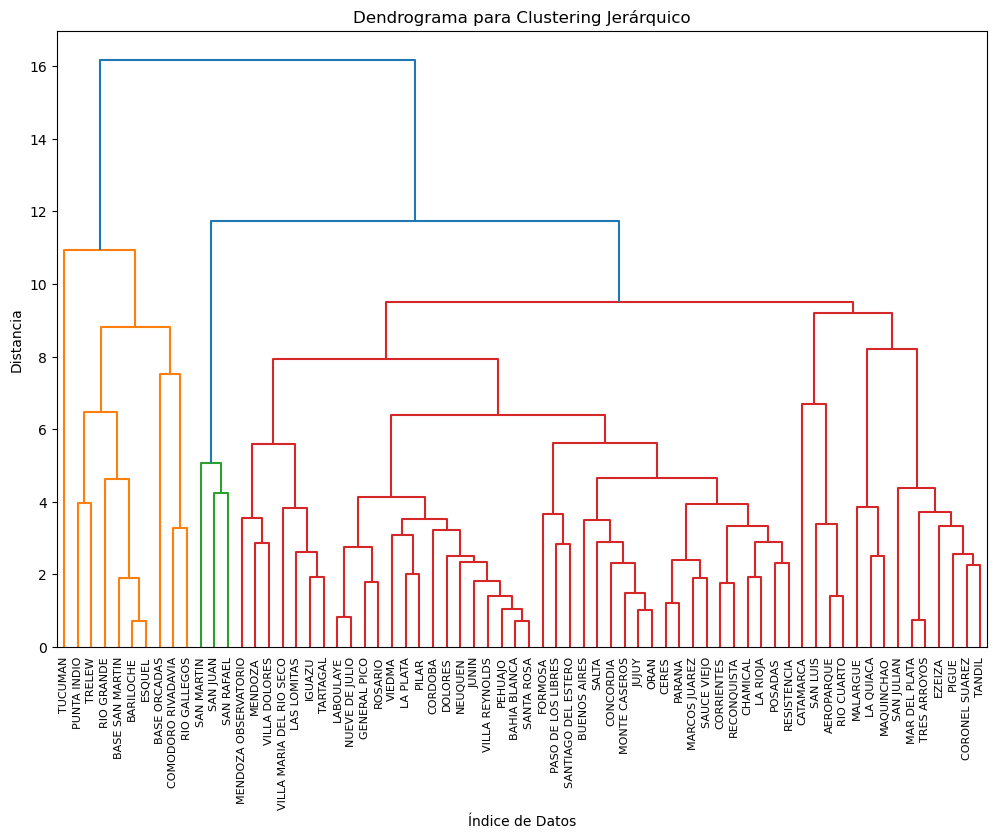

In [137]:
plot_dendrogram(linkage_matrix, normalized_data.index)

In [228]:

def plot_cluster_analysis(normalized_data, num_clusters=10, methods=['single', 'complete', 'average']):
    for method in methods:
        print(f"Method: {method}-linkage")

        # Calcular WCSS para diferentes números de clústeres
        wcss_values = []
        clusters_data = {}

        for k in range(1, num_clusters + 1):
            clusters = fcluster(linkage(normalized_data, method=method, metric='euclidean'), k, criterion='maxclust')
            cluster_centers = pd.DataFrame(index=range(1, k + 1), columns=normalized_data.columns)

            for i in range(1, k + 1):
                cluster_data = normalized_data[clusters == i].mean()
                cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(normalized_data.columns) else [np.nan] * len(normalized_data.columns)

            ssw = ((normalized_data - normalized_data.groupby(clusters).transform('mean')) ** 2).sum().sum()
            wcss_values.append(ssw)
            clusters_data[k] = clusters

        # Visualizar el diagrama de codo y la visualización de clústeres
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        # Gráfico 1: Diagrama de codo
        ax[0].plot(range(1, num_clusters + 1), wcss_values, marker='o', linestyle='-', color='b')
        ax[0].set_title(f'Elbow Method - {method}-linkage')
        ax[0].set_xlabel('Number of Clusters')
        ax[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')

        # Gráfico 2: Visualización de clústeres para un número específico de clústeres
        selected_clusters = 3  # Ajusta esto según tus necesidades
        ax[1].scatter(normalized_data['Temperatura_(C)'], normalized_data['Nubosidad_total_(octavos)'], c=clusters_data[selected_clusters], cmap='tab10')
        ax[1].set_title(f'Clustering - {method}-linkage (k={selected_clusters})')
        ax[1].set_xlabel('Temperatura (C)')
        ax[1].set_ylabel('Nubosidad_total')

        # Ajustes de diseño para evitar superposiciones
        plt.tight_layout()
        plt.show()

        print("\n------\n")



In [225]:

def plot_cluster_analysis(normalized_data, num_clusters=10, methods=[ 'complete']):
    for method in methods:
        print(f"Method: {method}-linkage")

        # Calcular WCSS para diferentes números de clústeres
        wcss_values = []
        clusters_data = {}

        for k in range(1, num_clusters + 1):
            clusters = fcluster(linkage(normalized_data, method=method, metric='euclidean'), k, criterion='maxclust')
            cluster_centers = pd.DataFrame(index=range(1, k + 1), columns=normalized_data.columns)

            for i in range(1, k + 1):
                cluster_data = normalized_data[clusters == i].mean()
                cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(normalized_data.columns) else [np.nan] * len(normalized_data.columns)

            ssw = ((normalized_data - normalized_data.groupby(clusters).transform('mean')) ** 2).sum().sum()
            wcss_values.append(ssw)
            clusters_data[k] = clusters

        # Visualizar el diagrama de codo y la visualización de clústeres
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        # Gráfico 1: Diagrama de codo
        ax[0].plot(range(1, num_clusters + 1), wcss_values, marker='o', linestyle='-', color='b')
        ax[0].set_title(f'Elbow Method - {method}-linkage')
        ax[0].set_xlabel('Number of Clusters')
        ax[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')

        # Gráfico 2: Visualización de clústeres para un número específico de clústeres
        selected_clusters = 3  # Ajusta esto según tus necesidades
        ax[1].scatter(normalized_data['Temperatura_(C)'], normalized_data['Nubosidad_total_(octavos)'], c=clusters_data[selected_clusters], cmap='tab10')
        ax[1].set_title(f'Clustering - {method}-linkage (k={selected_clusters})')
        ax[1].set_xlabel('Temperatura (C)')
        ax[1].set_ylabel('Nubosidad_total')

        # Ajustes de diseño para evitar superposiciones
        plt.tight_layout()
        plt.show()

        print("\n------\n")


Method: complete-linkage


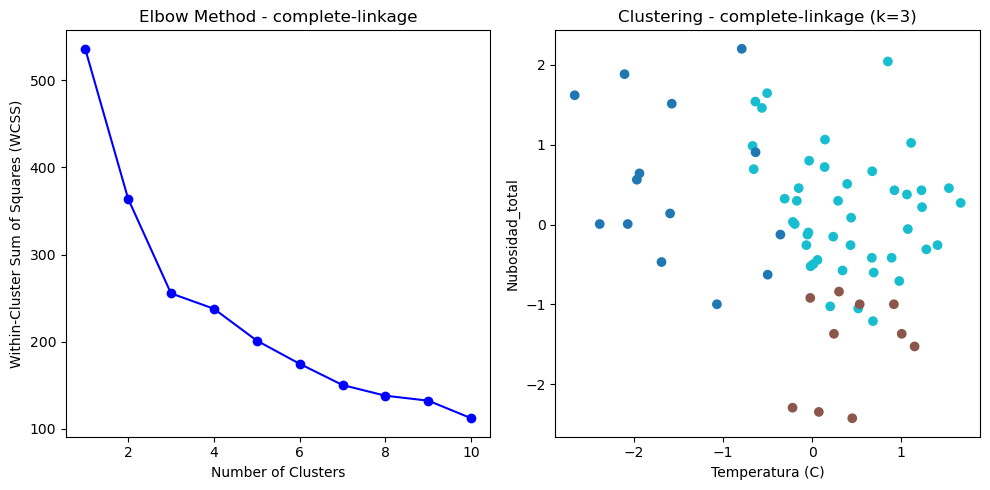


------



In [227]:
plot_cluster_analysis(normalized_data)

In [230]:

def plot_cluster_analysis(normalized_data, num_clusters=10, methods=['complete']):
    for method in methods:
        print(f"Method: {method}-linkage")

        # Calcular WCSS para diferentes números de clústeres
        wcss_values = []
        clusters_data = {}

        for k in range(1, num_clusters + 1):
            clusters = fcluster(linkage(normalized_data, method=method, metric='euclidean'), k, criterion='maxclust')
            cluster_centers = pd.DataFrame(index=range(1, k + 1), columns=normalized_data.columns)

            for i in range(1, k + 1):
                cluster_data = normalized_data[clusters == i].mean()
                cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(normalized_data.columns) else [np.nan] * len(normalized_data.columns)

            ssw = ((normalized_data - normalized_data.groupby(clusters).transform('mean')) ** 2).sum().sum()
            wcss_values.append(ssw)
            clusters_data[k] = clusters

        # Visualizar el diagrama de codo y la visualización de clústeres
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        # Gráfico 1: Diagrama de codo
        ax[0].plot(range(1, num_clusters + 1), wcss_values, marker='o', linestyle='-', color='b')
        ax[0].set_title(f'Elbow Method - {method}-linkage')
        ax[0].set_xlabel('Number of Clusters')
        ax[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')

        # Gráfico 2: Visualización de clústeres para un número específico de clústeres
        selected_clusters = 3  # Ajusta esto según tus necesidades
        ax[1].scatter(normalized_data['Temperatura_(C)'], normalized_data['Nubosidad_total_(octavos)'], c=clusters_data[selected_clusters], cmap='tab10')
        ax[1].set_title(f'Clustering - {method}-linkage (k={selected_clusters})')
        ax[1].set_xlabel('Temperatura (C)')
        ax[1].set_ylabel('Nubosidad_total')

        # Ajustes de diseño para evitar superposiciones
        plt.tight_layout()
        plt.show()

        print("\n------\n")


Method: complete-linkage


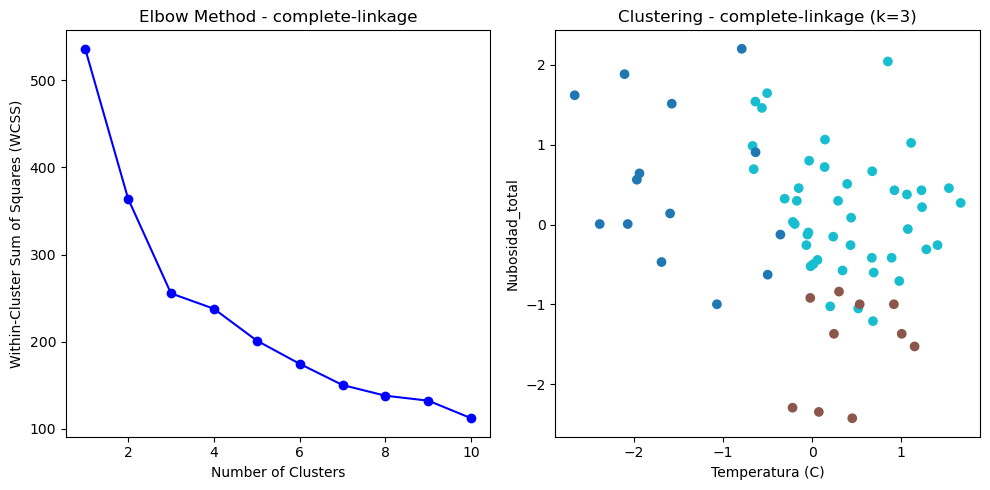


------



In [231]:
plot_cluster_analysis(normalized_data)

In [221]:

def plot_cluster_analysis(normalized_data, num_clusters=10, methods=['average']):
    for method in methods:
        print(f"Method: {method}-linkage")

        # Calcular WCSS para diferentes números de clústeres
        wcss_values = []
        clusters_data = {}

        for k in range(1, num_clusters + 1):
            clusters = fcluster(linkage(normalized_data, method=method, metric='euclidean'), k, criterion='maxclust')
            cluster_centers = pd.DataFrame(index=range(1, k + 1), columns=normalized_data.columns)

            for i in range(1, k + 1):
                cluster_data = normalized_data[clusters == i].mean()
                cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(normalized_data.columns) else [np.nan] * len(normalized_data.columns)

            ssw = ((normalized_data - normalized_data.groupby(clusters).transform('mean')) ** 2).sum().sum()
            wcss_values.append(ssw)
            clusters_data[k] = clusters

        # Visualizar el diagrama de codo y la visualización de clústeres
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        # Gráfico 1: Diagrama de codo
        ax[0].plot(range(1, num_clusters + 1), wcss_values, marker='o', linestyle='-', color='b')
        ax[0].set_title(f'Elbow Method - {method}-linkage')
        ax[0].set_xlabel('Number of Clusters')
        ax[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')

        # Gráfico 2: Visualización de clústeres para un número específico de clústeres
        selected_clusters = 3  # Ajusta esto según tus necesidades
        ax[1].scatter(normalized_data['Temperatura_(C)'], normalized_data['Nubosidad_total_(octavos)'], c=clusters_data[selected_clusters], cmap='tab10')
        ax[1].set_title(f'Clustering - {method}-linkage (k={selected_clusters})')
        ax[1].set_xlabel('Temperatura (C)')
        ax[1].set_ylabel('Nubosidad_total')

        # Ajustes de diseño para evitar superposiciones
        plt.tight_layout()
        plt.show()

        print("\n------\n")


Method: complete-linkage


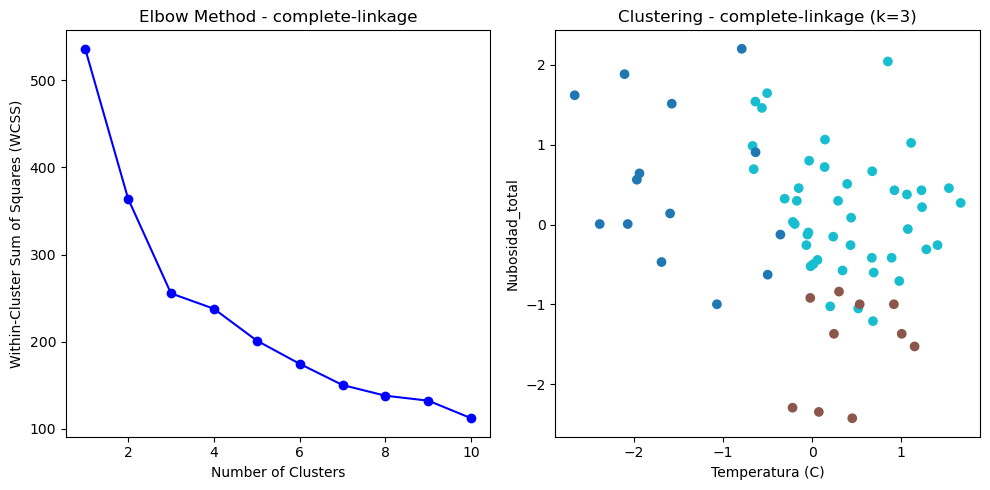


------



In [232]:
plot_cluster_analysis(normalized_data)

In [233]:
# @title
# Obtener asignaciones de clusters
##########################################################
##########################################################
##########################################################
num_clusters = 3
##########################################################
##########################################################
##########################################################


clusters_single = fcluster(Z_single, num_clusters, criterion='maxclust')
clusters_complete = fcluster(Z_complete, num_clusters, criterion='maxclust')
clusters_average = fcluster(Z_average, num_clusters, criterion='maxclust')


# Calcular las distancias entre los puntos (puedes ajustar la métrica según tus necesidades)
distances = pdist(normalized_data, metric='euclidean')

# Convertir las distancias a una matriz cuadrada
distance_matrix = squareform(distances)

# Calcular el enlace para el dendrograma
linkage_matrix = linkage(distance_matrix, method='average')

# Mostrar los centros de los clusters sin Normalizar
cluster_centers = pd.DataFrame(index=range(1, num_clusters + 1), columns=variables_clustering.columns)

for i in range(1, num_clusters + 1):
    cluster_data = variables_clustering[clusters_average == i].mean()
    cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(variables_clustering.columns) else [np.nan] * len(variables_clustering.columns)


/tmp/ipykernel_135741/1004838727.py:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


In [234]:
def metricas():
    print("Number of clusters:", num_clusters)
    print("Transformation: Standardize (Z)")
    print("Method: Average-linkage")
    print("Distance function: Euclidean")
    print("\nCluster centers:")
    print(cluster_centers)


In [236]:
metricas()

Number of clusters: 3
Transformation: Standardize (Z)
Method: Average-linkage
Distance function: Euclidean

Cluster centers:
  Temperatura_(C) Temperatura_maxima_(C) Temperatura_minima_(C)  \
1       11.060556              17.703889               5.465556   
2       17.553205              24.362019              11.872328   
3       19.533333              25.841667              14.241667   

  Humedad_relativa_(%) Velocidad_del_Viento_(km/h) Nubosidad_total_(octavos)  \
1            67.277666                    15.57591                  4.043889   
2            68.541574                    10.48529                  3.585904   
3            71.933333                   10.883333                  4.341667   

  Precipitacion_(mm) Frecuencia_dias_Precipitacion_>0.1_mm Cluster_kmean  
1          48.748078                              7.076463      2.466667  
2          72.156164                              6.473721      3.692308  
3          85.958333                                 8.225  

In [153]:

# Mostrar los centros de los clusters Normalizados
cluster_centers = pd.DataFrame(index=range(1, num_clusters + 1), columns=normalized_data.columns)
for i in range(1, num_clusters + 1):
    cluster_data = normalized_data[clusters_average == i].mean()
    cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(normalized_data.columns) else [np.nan] * len(normalized_data.columns)

print("Number of clusters:", num_clusters)
print("Transformation: Standardize (Z)")
print("Method: Average-linkage")
print("Distance function: Euclidean")
print("\nCluster centers:")
print(cluster_centers)

# Calcular métricas adicionales
wcss_values = []
for k in range(1, num_clusters + 1):
    cluster_data = normalized_data[clusters_average == k]
    ssw = ((cluster_data - cluster_data.mean(axis=0)) ** 2).sum().sum()
    wcss_values.append(ssw)

sst = ((normalized_data - normalized_data.mean()) ** 2).sum().sum()
bcss = sst - sum(wcss_values)


Number of clusters: 7
Transformation: Standardize (Z)
Method: Average-linkage
Distance function: Euclidean

Cluster centers:
  Temperatura_(C) Velocidad_del_Viento_(km/h) Nubosidad_total_(octavos)
1        -2.26536                    1.467171                  0.474231
2       -1.345344                    2.160375                  2.195918
3       -0.657348                    0.668635                  1.166649
4         0.13428                    0.091933                 -2.445152
5        0.522898                    1.437123                 -0.686037
6         0.34705                   -0.497006                 -0.246334
7        0.951816                   -0.075766                  2.869622


In [239]:
def metricas2 ():
    print("\nThe total sum of squares:", sst)
    print("Within-cluster sum of squares:")
    for i, wcss in enumerate(wcss_values):
        print(f"C{i + 1} : {wcss}")
    print("\nThe total within-cluster sum of squares:", sum(wcss_values))
    print("The between-cluster sum of squares:", bcss)
    print("The ratio of between to total sum of squares:", bcss / sst)

In [240]:
metricas2()


The total sum of squares: 201.0
Within-cluster sum of squares:
C1 : 4.153536757280289
C2 : 0.7962571338935469
C3 : 5.567752552300325
C4 : 0.5119644817367566
C5 : 1.4186377424527685
C6 : 58.39582128804216
C7 : 0.0

The total within-cluster sum of squares: 70.84396995570584
The between-cluster sum of squares: 130.15603004429414
The ratio of between to total sum of squares: 0.6475424380313142


In [154]:
print("\nThe total sum of squares:", sst)
print("Within-cluster sum of squares:")
for i, wcss in enumerate(wcss_values):
    print(f"C{i + 1} : {wcss}")
print("\nThe total within-cluster sum of squares:", sum(wcss_values))
print("The between-cluster sum of squares:", bcss)
print("The ratio of between to total sum of squares:", bcss / sst)


The total sum of squares: 201.0
Within-cluster sum of squares:
C1 : 4.153536757280289
C2 : 0.7962571338935469
C3 : 5.567752552300325
C4 : 0.5119644817367566
C5 : 1.4186377424527685
C6 : 58.39582128804216
C7 : 0.0

The total within-cluster sum of squares: 70.84396995570584
The between-cluster sum of squares: 130.15603004429414
The ratio of between to total sum of squares: 0.6475424380313142


In [246]:
# Agregar la columna 'Cluster' al DataFrame variables_clustering
variables_clustering['Cluster'] = clusters_average

def plot_scatter_with_clusters(variables_clustering):
    # Scatter plot con colores por clúster
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(data=variables_clustering, x='Temperatura_(C)', y='Nubosidad_total_(octavos)', hue='Cluster', palette='viridis', s=50)

    # Personalizar la leyenda para incluir todos los números de clúster únicos
    unique_labels = sorted(variables_clustering['Cluster'].unique())

    # Mostrar todos los números de clúster en la leyenda
    plt.legend(title='Cluster', loc='upper right', labels=unique_labels)

    plt.title('Scatter Plot con Colores por Clúster')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Humedad')

    plt.show()

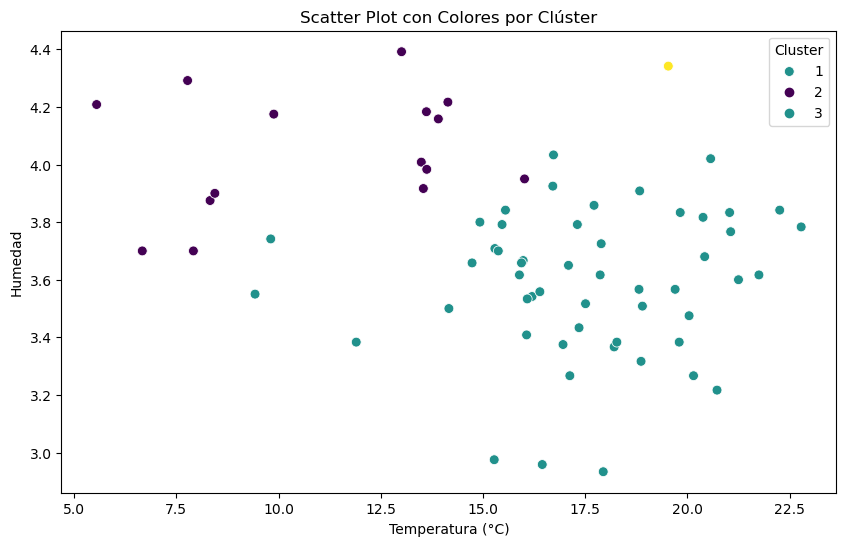

In [247]:
plot_scatter_with_clusters(variables_clustering)

In [248]:
gdf_jerarquico = gdf_median.groupby(['Estacion'])[['lat', 'long']].mean()
gdf_jerarquico['Estacion']= gdf_jerarquico.index
gdf_jerarquico = gdf_jerarquico.rename_axis('n')

variables_clustering['Estacion']= variables_clustering.index
variables_clustering = variables_clustering.rename_axis('Estacion')
variables_clustering = variables_clustering.rename_axis('n')


#variables_clustering.set_index('Estacion', inplace=True)


gdf_jerarquico['Estacion'] = gdf_jerarquico['Estacion'].str.strip()  # Eliminar espacios adicionales si los hubiera

# Fusionar gdf_jerarquico con variables_clustering
gdf_jerarquico = gdf_jerarquico.merge(variables_clustering[['Cluster']], left_on='Estacion', right_index=True, how='left')



In [249]:
mapeo = gpd.GeoDataFrame(gdf_jerarquico,
                         geometry=gpd.points_from_xy(gdf_jerarquico['long'],
                                                                gdf_jerarquico['lat']))

def plot_map_with_clusters(gdf_jerarquico, pais, mapeo):
    # Crear una figura y ejes
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plotear los límites del país
    pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

    # Colores automáticos basados en la cantidad de clusters
    palette = sns.color_palette("tab10", n_colors=len(gdf_jerarquico['Cluster'].unique()))
    sns.scatterplot(data=gdf_jerarquico, x='long', y='lat', hue='Cluster', palette=palette, ax=ax, s=50)

    # Ajustar los límites del gráfico
    x_min, y_min, x_max, y_max = mapeo.total_bounds
    margin_scale = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range
    ax.set_xlim(x_min_adjusted, x_max_adjusted)
    ax.set_ylim(y_min_adjusted, y_max_adjusted)

    # Mostrar el mapa
    plt.title('Mapa con Colores de Cluster')
    plt.legend(title='Cluster')
    plt.show()


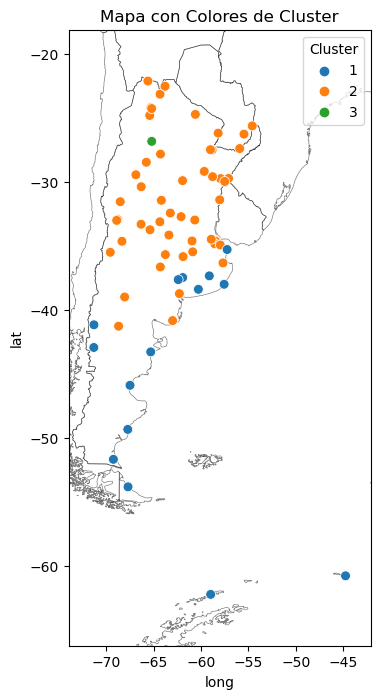

In [250]:
plot_map_with_clusters(gdf_jerarquico, pais, mapeo)

## Cluster KMeans

In [166]:
# @title
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


variables_clustering = gdf_median.groupby('Estacion')[['Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)',
                                               'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)',
                                               'Nubosidad_total_(octavos)', 'Precipitacion_(mm)',
                                               'Frecuencia_dias_Precipitacion_>0.1_mm']]

# Puedes realizar operaciones de agregación o análisis en los grupos si es necesario
# Por ejemplo, calcular la media de cada columna para cada estación
variables_clustering = variables_clustering.mean()


normalized_data = (variables_clustering - variables_clustering.mean()) / variables_clustering.std()


# Selecciona las columnas relevantes para el análisis de k-means
data_for_kmeans = normalized_data



# Especifica el número de clústeres (k) que deseas encontrar
k = 7

# Crea y ajusta el modelo k-means
kmeans = KMeans(n_clusters=k, random_state=42)
gdf_jerarquico['Cluster_kmean'] = kmeans.fit_predict(data_for_kmeans)


# Selecciona las columnas relevantes para el análisis de k-means


data_for_kmeans = variables_clustering[['Temperatura_(C)', 'Velocidad_del_Viento_(km/h)',
                                             'Nubosidad_total_(octavos)']]



# Crea y ajusta el modelo k-means
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=150, max_iter=1000, random_state=42)
variables_clustering['Cluster_kmean'] = kmeans.fit_predict(data_for_kmeans)

# Resultados del análisis de k-means
cluster_centers = kmeans.cluster_centers_
within_cluster_ss = np.zeros((k, 1))

for i in range(k):
    cluster_data = data_for_kmeans[variables_clustering['Cluster_kmean'] == i]
    within_cluster_ss[i, 0] = np.sum((cluster_data.values - cluster_centers[i:i+1, :]) ** 2)

total_within_cluster_ss = within_cluster_ss.sum()
total_sum_of_squares = np.sum((data_for_kmeans.values - np.mean(data_for_kmeans.values)) ** 2)
between_cluster_ss = total_sum_of_squares - total_within_cluster_ss
ratio_between_to_total_ss = between_cluster_ss / total_sum_of_squares


/home/martin/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [252]:
def metrica_k():
    print("Cluster centers:")
    print(pd.DataFrame(cluster_centers, columns=data_for_kmeans.columns))
    print("\nWithin-cluster sum of squares:")
    print(pd.DataFrame(within_cluster_ss, columns=['Within cluster S.S.']))
    print("\nThe total within-cluster sum of squares:", total_within_cluster_ss)
    print("The between-cluster sum of squares:", between_cluster_ss)
    print("The ratio of between to total sum of squares:", ratio_between_to_total_ss)
    

In [253]:
metrica_k()

Cluster centers:
  Temperatura_(C) Velocidad_del_Viento_(km/h) Nubosidad_total_(octavos)
1       11.060556                    15.57591                  4.043889
2       17.553205                    10.48529                  3.585904
3       19.533333                   10.883333                  4.341667

Within-cluster sum of squares:
   Within cluster S.S.
0            12.692905
1            29.163703
2            13.079306
3             9.148727
4            67.238860
5            52.962242
6            34.429984

The total within-cluster sum of squares: 218.7157259293839
The between-cluster sum of squares: 7072.191551366945
The ratio of between to total sum of squares: 0.970001576263292


# Análisis de Componentes Principales (PCA)

In [ ]:
gdf_median.info()

In [176]:
#gdf = gpd.read_file("gdf_median.gpkg")
#Leer archivo GeoPackage
#gdf = gpd.read_file("gdf_median.gpkg")

# Leer archivo GeoPackage
gdf = gdf_median

# Seleccionar las variables para el análisis de componentes principales
variables = ["Temperatura_(C)", "Temperatura_maxima_(C)", "Temperatura_minima_(C)", "Humedad_relativa_(%)", "Velocidad_del_Viento_(km/h)", "Nubosidad_total_(octavos)", "Precipitacion_(mm)"]

# Estandarizar los datos antes de aplicar PCA
scaler = StandardScaler()
gdf[variables] = scaler.fit_transform(gdf[variables])

# Aplicar PCA
pca = PCA()
gdf_pca = pd.DataFrame(pca.fit_transform(gdf[variables]), columns=[f"PC{i+1}" for i in range(len(variables))])


# Pregunta 1: Contar cuántas PC rescatan individualmente una heterogeneidad original mayor al 20%
pc_cumsum = np.cumsum(explained_variance_ratio)
pc_above_threshold = len(pc_cumsum[pc_cumsum > 0.2])


In [177]:
print(f"Hereogeneidad: {pc_above_threshold} PCs rescatan individualmente una heterogeneidad mayor al 20%")

Hereogeneidad: 7 PCs rescatan individualmente una heterogeneidad mayor al 20%


In [178]:
# Mostrar la varianza explicada por cada PC
explained_variance_ratio = pca.explained_variance_ratio_

In [179]:
print("Varianza explicada por cada PC:")
print(explained_variance_ratio)

Varianza explicada por cada PC:
[0.5029618  0.2292287  0.14268381 0.07118705 0.03864481 0.01141045
 0.00388336]


In [174]:
thresholds = [0.7, 0.8, 0.9, 0.95]
for threshold in thresholds:
    pc_to_reach_threshold = np.argmax(pc_cumsum > threshold) + 1
    print(f"Cantidad de Pcs: {pc_to_reach_threshold} PCs explican en conjunto una heterogeneidad mayor al {threshold*100}%")


Cantidad de Pcs: 2 PCs explican en conjunto una heterogeneidad mayor al 70.0%
Cantidad de Pcs: 3 PCs explican en conjunto una heterogeneidad mayor al 80.0%
Cantidad de Pcs: 4 PCs explican en conjunto una heterogeneidad mayor al 90.0%
Cantidad de Pcs: 5 PCs explican en conjunto una heterogeneidad mayor al 95.0%


In [173]:
# Seleccionar dos variables originales que mejor se correlacionen con las PC1, PC2 y PC3
selected_variables = ["Temperatura_maxima_(C)", "Precipitacion_(mm)"]  # Ajustar según tus necesidades

# Calcular la matriz de correlación entre las PC y las variables originales seleccionadas
correlation_matrix = pd.DataFrame(pca.components_.T, index=gdf[variables].columns, columns=[f"PC{i+1}" for i in range(len(variables))])
selected_variables_correlation = correlation_matrix.loc[selected_variables]




In [171]:
print("Correlación entre las variables originales seleccionadas y las PC:")
print(selected_variables_correlation)

Correlación entre las variables originales seleccionadas y las PC:
                             PC1       PC2       PC3       PC4       PC5  \
Temperatura_maxima_(C) -0.508337  0.112016  0.013822  0.199641  0.118833   
Precipitacion_(mm)     -0.368804 -0.401210  0.262702 -0.313822 -0.731669   

                             PC6       PC7  
Temperatura_maxima_(C)  0.727252 -0.382076  
Precipitacion_(mm)      0.009592  0.009276  


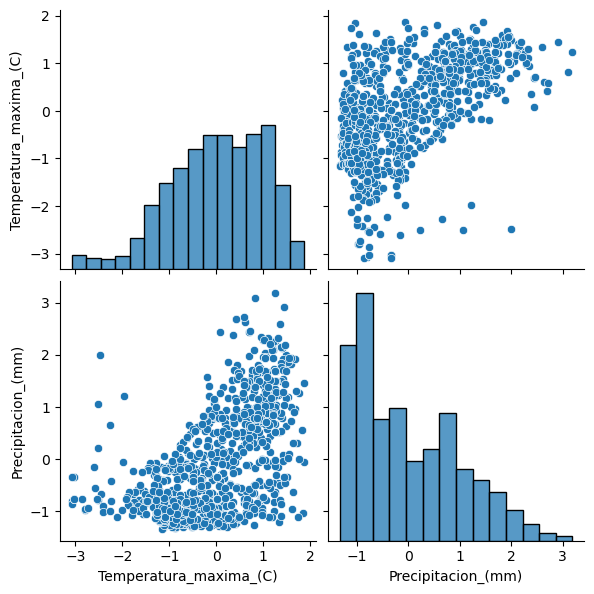

In [172]:
sns.pairplot(gdf, vars=selected_variables, height=3)
plt.show()